<h1><font color='blue'>Introduction</font></h1>

In the CMS experiment at the LHC, data certification (DC) and data quality monitoring (DQM) are a neccesary precursor to any physics analysis. However, there are two significant problems with the current approach. First of all, it is human driven, which means there is significant possibility for human error. Second of all, the monitoring elements they are able to evaluate show run level information, which means that their evaluation is limited in granularity seeing as runs are sub-divided into lumisections. Thus, if there are any problems at the lumisecion level, these could easily be overlooked by the shifter. In this notebook, we will evaluate the accuracy of shifter certification at the lumisection level for good runs in order to determine how many bad lumisections pass through unperceived. In order to focus the scope of this work, we will focus on Pixel detector, a crucial component in the tracking of charged particles being produced by the collisions at the center of CMS.

<h1><font color='blue'>Setup</font></h1>

We start by importing all the neccessary python libraries. Note that we will construct the autoencoder using Tensorflow and so we must import all the neccessary functions and classes.

In [1]:
# Importing basic tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import sys, os
import importlib
import seaborn as sns
from ast import literal_eval

# Importing AE related tools
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, Flatten, Reshape, Conv1D
from tensorflow.keras.saving import load_model
from tensorflow.keras.losses import kullback_leibler_divergence, mse
from tensorflow.keras.utils import plot_model
from tensorflow.math import reduce_mean
from sklearn.model_selection import train_test_split

# Importing user defined utilities for data manipulation, plotting, etc.
sys.path.append(os.path.abspath('utilities'))
import data_utils as datau
import json_utils
import refruns_utils
import plot_utils as pltu

# Setting seed for reproducibility
import random
import numpy as np
import tensorflow as tf
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

2023-11-21 03:03:33.232394: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 03:03:35.832968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
# In case of live editing of the utilities

# importlib.reload(data_utils)
# importlib.reload(json_utils)
# importlib.reload(refruns_utils)
importlib.reload(pltu)

<module 'plot_utils' from '/eos/home-i02/r/rcruzcan/SWAN_projects/ANN-FauxShifter/utilities/plot_utils.py'>

<h1><font color='blue'>Importing the data</font></h1>

<!--   - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1
  - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2
  - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_3
  - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_4
  - PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_1
  - PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_2
  - PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_3
  - PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_4
  - PixelPhase1/Tracks/PXBarrel/size_PXLayer_1
  - PixelPhase1/Tracks/PXBarrel/size_PXLayer_2
  - PixelPhase1/Tracks/PXBarrel/size_PXLayer_3
  - PixelPhase1/Tracks/PXBarrel/size_PXLayer_4
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_+1
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_+2
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_+3
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_-1
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_-2
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_-3
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_+1
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_+2
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_+3
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_-1
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_-2
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_-3
  - PixelPhase1/Tracks/PXForward/size_PXDisk_+1
  - PixelPhase1/Tracks/PXForward/size_PXDisk_+2
  - PixelPhase1/Tracks/PXForward/size_PXDisk_+3
  - PixelPhase1/Tracks/PXForward/size_PXDisk_-1
  - PixelPhase1/Tracks/PXForward/size_PXDisk_-2
  - PixelPhase1/Tracks/PXForward/size_PXDisk_-3
  - PixelPhase1/Tracks/charge_PXBarrel
  - PixelPhase1/Tracks/charge_PXForward
  - PixelPhase1/Tracks/clusterposition_zphi_ontrack
  - PixelPhase1/Tracks/num_clusters_ontrack_PXBarrel
  - PixelPhase1/Tracks/num_clusters_ontrack_PXForward -->
  
<!-- <h2> Importing the data </h2> -->
  
We can have a look at all of the available monitoring elements by loading one of the CSV data files into a pandas dataframe and taking a look at the `'hname'` column which contains the histogram/monitoring element name.

In [6]:
DF2017ZeroBias_df = pd.read_csv('data/DF2017B_1D_Complete/ZeroBias_2017B_DataFrame_1D_1.csv')

print('Available monitoring elements:')
DF2017ZeroBias_df['hname'].unique().tolist()

Available monitoring elements:


['goodvtxNbr',
 'adc_PXLayer_1',
 'adc_PXLayer_2',
 'adc_PXLayer_3',
 'adc_PXLayer_4',
 'adc_PXDisk_+1',
 'adc_PXDisk_+2',
 'adc_PXDisk_+3',
 'adc_PXDisk_-1',
 'adc_PXDisk_-2',
 'adc_PXDisk_-3',
 'num_clusters_ontrack_PXBarrel',
 'num_clusters_ontrack_PXForward',
 'chargeInner_PXLayer_1',
 'chargeInner_PXLayer_2',
 'chargeInner_PXLayer_3',
 'chargeInner_PXLayer_4',
 'chargeOuter_PXLayer_1',
 'chargeOuter_PXLayer_2',
 'chargeOuter_PXLayer_3',
 'chargeOuter_PXLayer_4',
 'size_PXLayer_1',
 'size_PXLayer_2',
 'size_PXLayer_3',
 'size_PXLayer_4',
 'charge_PXDisk_+1',
 'charge_PXDisk_+2',
 'charge_PXDisk_+3',
 'charge_PXDisk_-1',
 'charge_PXDisk_-2',
 'charge_PXDisk_-3',
 'size_PXDisk_+1',
 'size_PXDisk_+2',
 'size_PXDisk_+3',
 'size_PXDisk_-1',
 'size_PXDisk_-2',
 'size_PXDisk_-3',
 'MainDiagonal Position',
 'NumberOfClustersInPixel',
 'NumberOfClustersInStrip',
 'NormalizedHitResiduals_TEC__wheel__1',
 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__1',
 'NormalizedHitResiduals_TEC__

We can see here that there is large number of possible monitoring elements we could use. However, for our purposes and for the sake of simplicity, we will only focus on a subset of the available monitoring element, namely a subset of the ones which correspond to the Pixel detector. We define a list containing the name of all the monitoring element we will be using.

In [7]:
monitoring_elems = [
    'chargeInner_PXLayer_1',
    'chargeInner_PXLayer_2',
    'chargeInner_PXLayer_3',
    'chargeInner_PXLayer_4',
    'chargeOuter_PXLayer_1',
    'chargeOuter_PXLayer_2',
    'chargeOuter_PXLayer_3',
    'chargeOuter_PXLayer_4',
    'charge_PXDisk_+1',
    'charge_PXDisk_+2',
    'charge_PXDisk_+3',
    'charge_PXDisk_-1',
    'charge_PXDisk_-2',
    'charge_PXDisk_-3',
    'num_clusters_ontrack_PXBarrel',
    'num_clusters_ontrack_PXForward',
]

If we haven't done so already, we would need to process the original `.csv` files. They are assumed to be in a directory named `data` and, when we use `data_utils.dump1dtocsv`, we extract the relevant monitoring element histogram for all the runs in all the available files and then we dump them into their own files. This would need to be done only once.

In [11]:
# Note: SHOULD ONLY BE RUN ONCE TO PROCESS FILES
all_files = os.listdir('proc_data')
all_files = [os.path.join('./proc_data', file) for file in all_files]

for i, me in enumerate(monitoring_elems):
    fname = './proc_data/ZeroBias_2017UL_DataFrame_' + me + '.csv'
    if fname in all_files:
        continue
    data_utils.dump1dtocsv(monitoring_elems[i], monitoring_elems, verbose=False)

With the monitoring element histograms now in the `proc_data` directory, we proceed to load all of the histograms into a single dataframe name `me_df`.

In [8]:
all_files = glob.glob('./proc_data/*')
me_dict = {}

for i, file in enumerate(all_files):
    me_name = file[38:][0:-4]
    print('Reading {}'.format(file))
    if i == 0:
        me_df = pd.read_csv(file)
        me_df.rename(columns={'histo': me_name+'_hist'}, inplace=True)
        me_df[me_name+'_hist'] = me_df[me_name+'_hist'].apply(literal_eval).apply(np.array)
        continue
    me_df = me_df.join(pd.read_csv(file)['histo'].rename(me_name+'_hist'))
    me_df[me_name+'_hist'] = me_df[me_name+'_hist'].apply(literal_eval).apply(np.array)

Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeInner_PXLayer_1.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeInner_PXLayer_2.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeInner_PXLayer_3.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeInner_PXLayer_4.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeOuter_PXLayer_1.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeOuter_PXLayer_2.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeOuter_PXLayer_3.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeOuter_PXLayer_4.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_+1.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_+2.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_+3.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_-1.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_-2.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_-3.csv
Reading ./proc_data/Ze

Taking a closer look at the details of the data we just loaded...

In [9]:
me_df.head()

Unnamed: 0  fromrun  fromlumi                  hname  entries     Xmax  \
0           0   299178       105  chargeInner_PXLayer_1   213731  80000.0   
1           1   299178       106  chargeInner_PXLayer_1   202644  80000.0   
2           2   297282        13  chargeInner_PXLayer_1   190027  80000.0   
3           3   297282        14  chargeInner_PXLayer_1   190544  80000.0   
4           4   297282        15  chargeInner_PXLayer_1   197012  80000.0   

   Xmin  Xbins  metype                         chargeInner_PXLayer_1_hist  \
0   0.0    100       3  [0, 125, 780, 1459, 2153, 2785, 3088, 3388, 35...   
1   0.0    100       3  [0, 109, 728, 1419, 2019, 2612, 2925, 3215, 34...   
2   0.0    100       3  [0, 112, 493, 998, 1616, 2256, 2899, 3695, 416...   
3   0.0    100       3  [0, 110, 481, 970, 1610, 2338, 2861, 3701, 427...   
4   0.0    100       3  [0, 92, 510, 1027, 1660, 2390, 3021, 3854, 430...   

   ...                         chargeOuter_PXLayer_3_hist  \
0  ...  [0, 0, 3, 34, 68, 123, 143, 157, 153, 127, 143...   
1  ...  [0, 0, 1, 40, 75, 122, 136, 138, 164, 151, 132...   
2  ...  [0, 0, 1, 78, 183, 240, 255, 247, 261, 272, 31...   
3  ...  [0, 0, 2, 91, 198, 254, 261, 233, 258, 311, 32...   
4  ...  [0, 0, 3, 87, 227, 263, 267, 267, 280, 338, 30...   

                          chargeOuter_PXLayer_4_hist  \
0  [0, 0, 0, 7, 44, 65, 97, 100, 103, 116, 112, 1...   
1  [0, 0, 0, 5, 45, 82, 103, 87, 91, 75, 86, 86, ...   
2  [0, 0, 0, 43, 145, 179, 220, 206, 205, 229, 24...   
3  [0, 0, 0, 43, 166, 189, 193, 235, 202, 227, 25...   
4  [0, 0, 0, 38, 138, 239, 235, 234, 212, 218, 27...   

                               charge_PXDisk_+1_hist  \
0  [0, 0, 0, 0, 2, 88, 97, 114, 121, 110, 103, 13...   
1  [0, 0, 0, 0, 0, 86, 101, 79, 103, 120, 103, 13...   
2  [0, 0, 0, 1, 3, 249, 291, 304, 340, 388, 447, ...   
3  [0, 0, 0, 1, 0, 234, 321, 298, 332, 383, 461, ...   
4  [0, 0, 0, 0, 2, 240, 301, 310, 363, 397, 468, ...   

                               charge_PXDisk_+2_hist  \
0  [0, 0, 0, 0, 0, 37, 67, 66, 69, 73, 80, 81, 10...   
1  [0, 0, 0, 0, 1, 42, 71, 76, 70, 77, 67, 104, 1...   
2  [0, 0, 0, 0, 0, 151, 216, 205, 197, 237, 278, ...   
3  [0, 0, 0, 0, 0, 159, 216, 204, 212, 240, 322, ...   
4  [0, 0, 1, 0, 0, 169, 221, 181, 232, 255, 277, ...   

                               charge_PXDisk_+3_hist  \
0  [0, 0, 0, 0, 0, 34, 69, 62, 64, 79, 72, 74, 91...   
1  [0, 0, 0, 0, 0, 41, 54, 65, 75, 74, 65, 74, 95...   
2  [0, 0, 0, 0, 0, 193, 262, 226, 177, 204, 224, ...   
3  [0, 0, 0, 0, 0, 202, 278, 197, 195, 208, 266, ...   
4  [0, 0, 0, 0, 0, 168, 269, 217, 216, 209, 259, ...   

                               charge_PXDisk_-1_hist  \
0  [0, 0, 0, 0, 0, 71, 111, 109, 93, 96, 112, 129...   
1  [0, 0, 0, 1, 0, 56, 99, 93, 115, 104, 116, 134...   
2  [0, 0, 0, 0, 1, 208, 250, 252, 273, 281, 329, ...   
3  [0, 0, 0, 0, 0, 204, 303, 261, 257, 292, 350, ...   
4  [0, 0, 0, 0, 2, 201, 318, 251, 295, 305, 374, ...   

                               charge_PXDisk_-2_hist  \
0  [0, 0, 0, 0, 0, 57, 89, 90, 72, 109, 90, 110, ...   
1  [0, 0, 0, 0, 1, 45, 82, 77, 86, 86, 83, 140, 1...   
2  [0, 0, 0, 0, 0, 180, 261, 265, 260, 308, 337, ...   
3  [0, 0, 0, 0, 0, 190, 256, 247, 282, 313, 341, ...   
4  [0, 0, 0, 0, 0, 199, 262, 269, 247, 283, 363, ...   

                               charge_PXDisk_-3_hist  \
0  [0, 0, 0, 0, 0, 47, 56, 85, 64, 85, 90, 90, 10...   
1  [0, 0, 0, 0, 0, 49, 81, 69, 68, 78, 72, 106, 8...   
2  [0, 0, 0, 0, 0, 147, 237, 220, 253, 282, 283, ...   
3  [0, 0, 0, 0, 0, 173, 271, 225, 238, 287, 299, ...   
4  [0, 0, 0, 0, 0, 155, 243, 249, 236, 277, 323, ...   

                  num_clusters_ontrack_PXBarrel_hist  \
0  [0, 566, 0, 2, 7, 34, 55, 87, 129, 157, 198, 2...   
1  [0, 538, 0, 3, 10, 24, 48, 70, 124, 164, 205, ...   
2  [0, 424, 0, 1, 2, 11, 39, 72, 140, 194, 231, 2...   
3  [0, 427, 0, 2, 1, 11, 32, 60, 116, 163, 230, 2...   
4  [0, 419, 0, 2, 6, 19, 37, 84, 131, 182, 223, 2...   

              

In [10]:
me_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28335 entries, 0 to 28334
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           28335 non-null  int64  
 1   fromrun                              28335 non-null  int64  
 2   fromlumi                             28335 non-null  int64  
 3   hname                                28335 non-null  object 
 4   entries                              28335 non-null  int64  
 5   Xmax                                 28335 non-null  float64
 6   Xmin                                 28335 non-null  float64
 7   Xbins                                28335 non-null  int64  
 8   metype                               28335 non-null  int64  
 9   chargeInner_PXLayer_1_hist           28335 non-null  object 
 10  chargeInner_PXLayer_2_hist           28335 non-null  object 
 11  chargeInner_PXLayer_3_hist  

We can see that in this dataframe we have the following columns of interest: 

    - `fromrun`: the run number to which the monitoring element histograms correspond to
    - `fromlumi`: the lumisection to which the monitoring element histograms correspond to
    - `entries`: number of entries in the histogram
    - `chargeInnerPXLayer1_hist`, `chargeOuter_PXLayer_3_hist`, etc: histogram bins
<!--     - `hname`: name of the monitoring element histogram -->

    
The rest of the elements of the histograms are not of interest to us, so we go ahead and drop them.

In [11]:
me_df.drop(['hname', 'Unnamed: 0', 'Xmax', 'Xmin', 'Xbins', 'metype'], axis=1, inplace=True)
me_df.set_index(['fromrun', 'fromlumi'], inplace=True)
me_df.sort_index(level=['fromrun', 'fromlumi'], inplace=True)
me_df.reset_index(inplace=True)

In [11]:
me_df.head()

fromrun  fromlumi  entries  \
0   297047         1    96516   
1   297047         2    98219   
2   297047         3   105896   
3   297047         4   119261   
4   297047         5   125286   

                          chargeInner_PXLayer_1_hist  \
0  [0, 39, 198, 378, 571, 784, 1068, 1295, 1465, ...   
1  [0, 44, 187, 394, 635, 785, 1100, 1309, 1528, ...   
2  [0, 51, 185, 378, 592, 907, 1157, 1460, 1598, ...   
3  [0, 35, 192, 338, 596, 909, 1201, 1512, 1759, ...   
4  [0, 37, 192, 369, 674, 932, 1245, 1520, 1946, ...   

                          chargeInner_PXLayer_2_hist  \
0  [0, 0, 28, 88, 108, 121, 157, 161, 163, 129, 1...   
1  [0, 0, 26, 84, 109, 120, 152, 146, 138, 156, 1...   
2  [0, 0, 32, 84, 111, 135, 140, 143, 155, 166, 1...   
3  [0, 1, 32, 98, 160, 184, 193, 174, 178, 160, 1...   
4  [0, 0, 39, 104, 168, 205, 191, 200, 184, 201, ...   

                          chargeInner_PXLayer_3_hist  \
0  [0, 0, 1, 23, 38, 67, 84, 69, 58, 85, 81, 81, ...   
1  [0, 0, 0, 24, 48, 53, 86, 67, 64, 61, 57, 70, ...   
2  [0, 0, 2, 32, 45, 73, 66, 80, 78, 93, 89, 70, ...   
3  [0, 0, 3, 26, 61, 74, 98, 93, 80, 89, 85, 100,...   
4  [0, 0, 3, 25, 82, 82, 109, 78, 102, 101, 105, ...   

                          chargeInner_PXLayer_4_hist  \
0  [0, 0, 0, 10, 32, 35, 72, 55, 61, 48, 59, 57, ...   
1  [0, 0, 0, 6, 34, 48, 54, 64, 46, 70, 65, 56, 4...   
2  [0, 0, 0, 15, 29, 52, 63, 69, 55, 52, 64, 62, ...   
3  [0, 0, 0, 12, 42, 52, 86, 70, 68, 73, 72, 65, ...   
4  [0, 0, 0, 8, 42, 56, 82, 76, 69, 75, 89, 86, 8...   

                          chargeOuter_PXLayer_1_hist  \
0  [0, 13, 109, 232, 381, 557, 791, 997, 1155, 13...   
1  [0, 17, 109, 272, 381, 542, 699, 941, 1168, 12...   
2  [0, 20, 109, 270, 410, 596, 810, 986, 1236, 14...   
3  [0, 16, 94, 236, 393, 645, 809, 1181, 1370, 16...   
4  [0, 21, 99, 284, 450, 663, 915, 1186, 1497, 17...   

                          chargeOuter_PXLayer_2_hist  \
0  [0, 0, 16, 61, 88, 128, 135, 130, 133, 112, 12...   
1  [0, 0, 13, 59, 99, 125, 122, 132, 113, 121, 12...   
2  [0, 0, 28, 56, 107, 108, 136, 131, 144, 138, 1...   
3  [0, 0, 21, 67, 107, 180, 158, 178, 198, 167, 1...   
4  [0, 0, 30, 91, 137, 143, 192, 183, 154, 161, 1...   

                          chargeOuter_PXLayer_3_hist  \
0  [0, 0, 1, 19, 49, 67, 87, 83, 88, 68, 84, 78, ...   
1  [0, 0, 1, 18, 47, 72, 73, 92, 92, 85, 76, 75, ...   
2  [0, 0, 3, 21, 55, 88, 104, 77, 85, 81, 94, 92,...   
3  [0, 0, 0, 27, 53, 84, 101, 114, 92, 113, 126, ...   
4  [0, 0, 0, 31, 60, 99, 121, 91, 120, 98, 126, 1...   

                          chargeOuter_PXLayer_4_hist  \
0  [0, 0, 0, 8, 31, 40, 67, 70, 61, 63, 58, 53, 6...   
1  [0, 0, 0, 3, 40, 59, 72, 56, 53, 57, 66, 72, 6...   
2  [0, 0, 0, 4, 39, 62, 71, 52, 62, 59, 71, 58, 5...   
3  [0, 0, 0, 9, 43, 67, 69, 69, 70, 95, 85, 73, 8...   
4  [0, 0, 0, 7, 37, 78, 91, 75, 68, 78, 77, 65, 7...   

                               charge_PXDisk_+1_hist  \
0  [0, 0, 0, 0, 0, 43, 62, 67, 61, 61, 55, 78, 81...   
1  [0, 0, 0, 0, 1, 49, 63, 47, 58, 52, 62, 62, 82...   
2  [0, 0, 1, 0, 0, 48, 68, 62, 69, 66, 75, 68, 90...   
3  [0, 0, 0, 0, 0, 43, 76, 85, 76, 88, 77, 91, 95...   
4  [0, 0, 0, 0, 0, 60, 97, 83, 85, 90, 94, 83, 11...   

                               charge_PXDisk_+2_hist  \
0  [0, 0, 0, 0, 0, 17, 37, 35, 43, 38, 36, 64, 49...   
1  [0, 0, 0, 0, 0, 31, 47, 41, 39, 42, 50, 58, 46...   
2  [0, 0, 0, 0, 0, 33, 54, 39, 35, 47, 45, 49, 50...   
3  [0, 0, 0, 0, 0, 35, 36, 30, 53, 56, 54, 69, 69...   
4  [0, 0, 0, 0, 0, 26, 54, 51, 48, 64, 54, 46, 77...   

                               charge_PXDisk_+3_hist  \
0  [0, 0, 0, 0, 0, 22, 37, 44, 53, 40, 34, 32, 41...   
1  [0, 0, 0, 0, 0, 26, 50, 28, 43, 38, 45, 40, 38...   
2  [0, 0, 0, 0, 0, 40, 36, 38, 40, 46, 39, 39, 55...   
3  [0, 0, 0, 0, 0, 30, 46, 51, 42, 34, 45, 59, 57...   
4  [0, 0, 0, 0, 0, 26, 48, 42, 34, 41, 47, 57, 67...   

                               charge_PXDisk_-1_hist  \
0  [0, 0, 0, 0, 0, 43, 62, 63, 68, 67, 71

We can take a look at the range of run numbers we will be working with and the total number of runs.

In [12]:
print('From', me_df['fromrun'].unique().min(), 'to', me_df['fromrun'].unique().max())
print('Number of runs:', len(me_df['fromrun'].unique()))

From 297047 to 299329
Number of runs: 135


Something we need to know is what reference run was used for each of the runs. This will allow us to disinguish which runs will make up our testing dataset (good runs), threshold dataset (bad runs used to get the threshold) and training dataset (reference which is used by all of the runs in both the testing and threshold dataset). We thus make a column which contains the reference run used for each run. This information is obtained from `CerHelper_AllRuns_RefRuns.json` which was sourced from a DC tool, Certification Helper, in which shifters input their certification during shifts along with the reference run used.

In [13]:
refruns = [refruns_utils.get_reference_run(i, jsonfile='CertHelper_AllRuns_RefRuns.json') for i in me_df['fromrun'].unique().tolist()]
refruns_dict = dict(zip(me_df['fromrun'].unique(), refruns))
me_df['refrun'] = me_df['fromrun'].map(refruns_dict)

We also make a mask column which has True if the run is a reference run and False otherwise so that we can know which run is a reference run.

In [14]:
isref = [run in refruns for run in me_df['fromrun'].unique()]
isref_dict = dict(zip(me_df['fromrun'].unique(), isref))
me_df['isref'] = me_df['fromrun'].map(isref_dict)

With this new information, we can start segmenting our data. Firstly, we get only the runs that are reference runs.

In [15]:
meRR_df = me_df[me_df['isref']==True]
meRR_df['fromrun'].unique()

array([297178])

We can check the amount of lumisections in the singularly available reference run in our data by just checking the amount of rows in this dataframe.

In [16]:
print('Amount of LSs in reference run 297178 is', len(meRR_df))

Amount of LSs in reference run 297178 is 1378


We now want to construct a dataframe (view) which only contains runs that are not reference runs themselves. Moreover, we make sure that the reference run thas was used for these runs is found in the `meRR_df` dataframe.

In [17]:
menotRR_df = me_df[me_df['isref']==False]
menotRR_df = menotRR_df[menotRR_df['refrun'] != -1]
menotRR_df['fromrun'].unique()

array([297047, 297050, 297057, 297099, 297101, 297113, 297114, 297169,
       297175, 297177, 297179, 297211, 297215, 297218, 297225, 297296,
       297411, 297426, 297431, 297434, 297468, 297474, 297483, 297486,
       297503, 297557, 297598, 297604, 297620, 297659, 297664, 297670,
       297674, 297678, 297722, 298997, 299000, 299061, 299065, 299067,
       299096, 299149, 299178, 299184, 299185, 299317, 299325, 299327,
       299329])

In [18]:
menotRR_df['refrun'].unique()

array([297178])

`menotRR_df` contains runs and lumisections that were certified as good or bad. We thus separate them into their own dataframes using a golden JSON which lists the runs and the corresponding lumisections which were certified as good, meaning that if a run and lumisection combination is not found listed in this file, they were certified as bad.

In [19]:
megood_df = menotRR_df[json_utils.injson(menotRR_df['fromrun'].to_list(), menotRR_df['fromlumi'].to_list(), jsonfile='GoldenJSON17.json')]
mebad_df = menotRR_df[~json_utils.injson(menotRR_df['fromrun'].to_list(), menotRR_df['fromlumi'].to_list(), jsonfile='GoldenJSON17.json')]

So in the end we have:
- `meRR_df` = dataframe which contains all available reference run
- `menotRR_df` = dataframe which contains all available non-reference runs which have a reference run which is available in `meRR_df`
- `megood_df` = dataframe containing the subset of runs found in `menotRR_df` which were certified as good
- `mebad_df` = same as `megood_df`, but runs that were certified as bad instead

<h1><font color='blue'>Exploring data and constructing the training dataset</font></h1>

Before start properly constructing the autoencoder ensemble, we chose a particular monitoring element for tuning and testing our model. For this, we choose the monitoring element `chargeInnerPXLayer1_1`. Before we actually construct the model, it is useful to take a look at what the histograms actually look like. We therefore, as an example, construct the `chargeInnerPXLayer1_1` histogram for the first 40 lumisections of run 297178, as this run is a reference run and will give us an idea of what a good run looks like.

<!-- We now get the training data from the `refruns_df`. In this case, we are going to train on the run 297178 data. Note that `X_train` here will be a numpy array where each row is a LS of the reference run, and each column will be a bin in the corresponding monitoring element histogram. -->

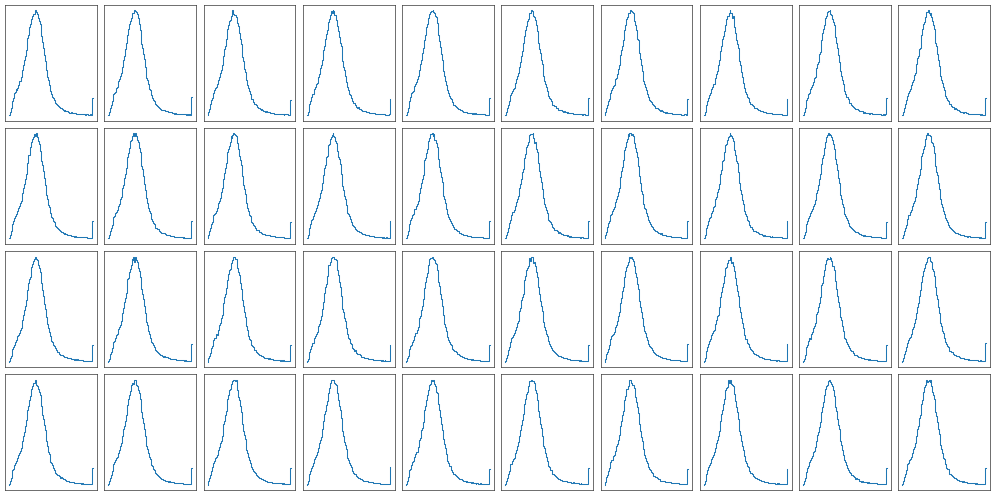

In [28]:
bins = np.arange(0,102)
fig, axes = plt.subplots(4, 10, figsize=(20,10), dpi=50)
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.step(bins, meRR_df[meRR_df['fromrun']==297178]['chargeInner_PXLayer_1_hist'].values[i])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

At a first glance, the histograms look nearly identical. Notice that after bin 60, the histogram drops of to 0 and that the main feature of all of the histograms is the peak on the left hand side.

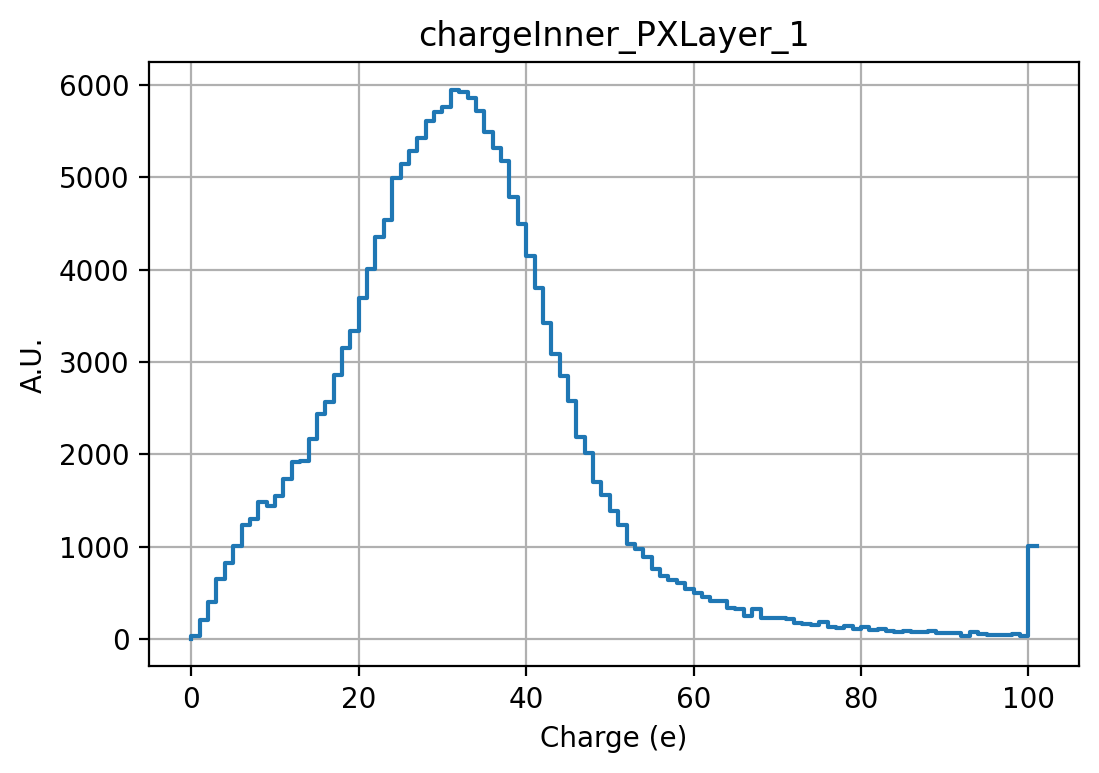

In [31]:
fig, ax = plt.subplots(dpi=200)
ax.step(np.arange(0,102), meRR_df[meRR_df['fromrun']==297178]['chargeInner_PXLayer_1_hist'].values[0])
ax.set_title('chargeInner_PXLayer_1')
ax.set_xlabel('Charge (e)')
ax.set_ylabel('A.U.')
ax.grid()

Given that we are able to characterize the behavior of these monitoring elements by only considering those bins near the peak, we will be choosing only the first 62 bins. This will shrink our dataset to a more manageable level, appropriate for the hardware limitations present in this project. With this in mind, we can go ahead and create our training dataset from the reference run that is available in our data. With the current file being used, we only have the reference run 297178 available for that, but this suffices as it is relatively long run and so contains a substantial amount of statistics. Furthermore, this project is a proof of concept so, although further testing with more reference runs would be required for a more comprehensive evaluation of the anomaly detection approach used here, it is enough for our purposes.

In [32]:
X_train = np.stack(meRR_df[meRR_df['fromrun']==297178]['chargeInner_PXLayer_1_hist'].values)[:,:62]

In order to visualize the behavior and shape of the histogram along all of the lumisections, we can plot the data as a heatmap. Each row will correspond to a lumisection and each column will be a bin in the 62 bin wide histograms of our dataset.

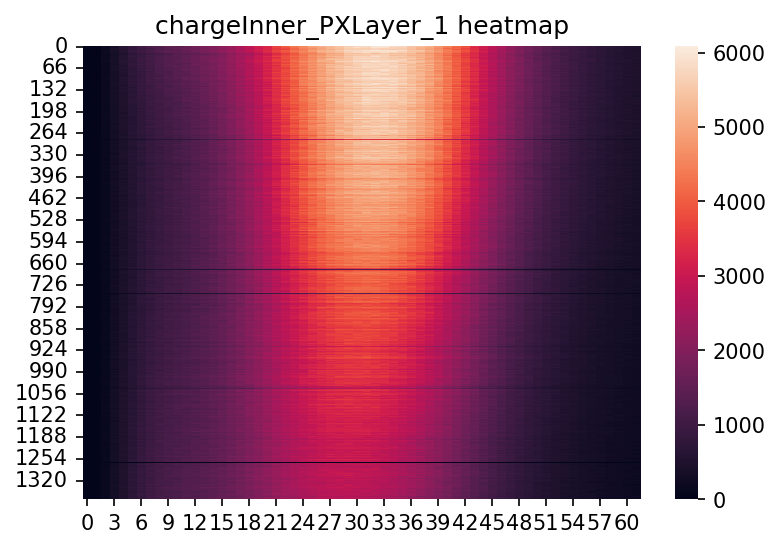

In [33]:
pltu.heatmap(X_train, title='chargeInner_PXLayer_1 heatmap', dpi=150)
plt.show()

We can see that a small subset of the lumisections in this dataset seem to be missing. In order for the autoencoder to converge and be able to reconstruct the histograms, we will normalize our dataset by having all of the histograms have an under them equal to unity.

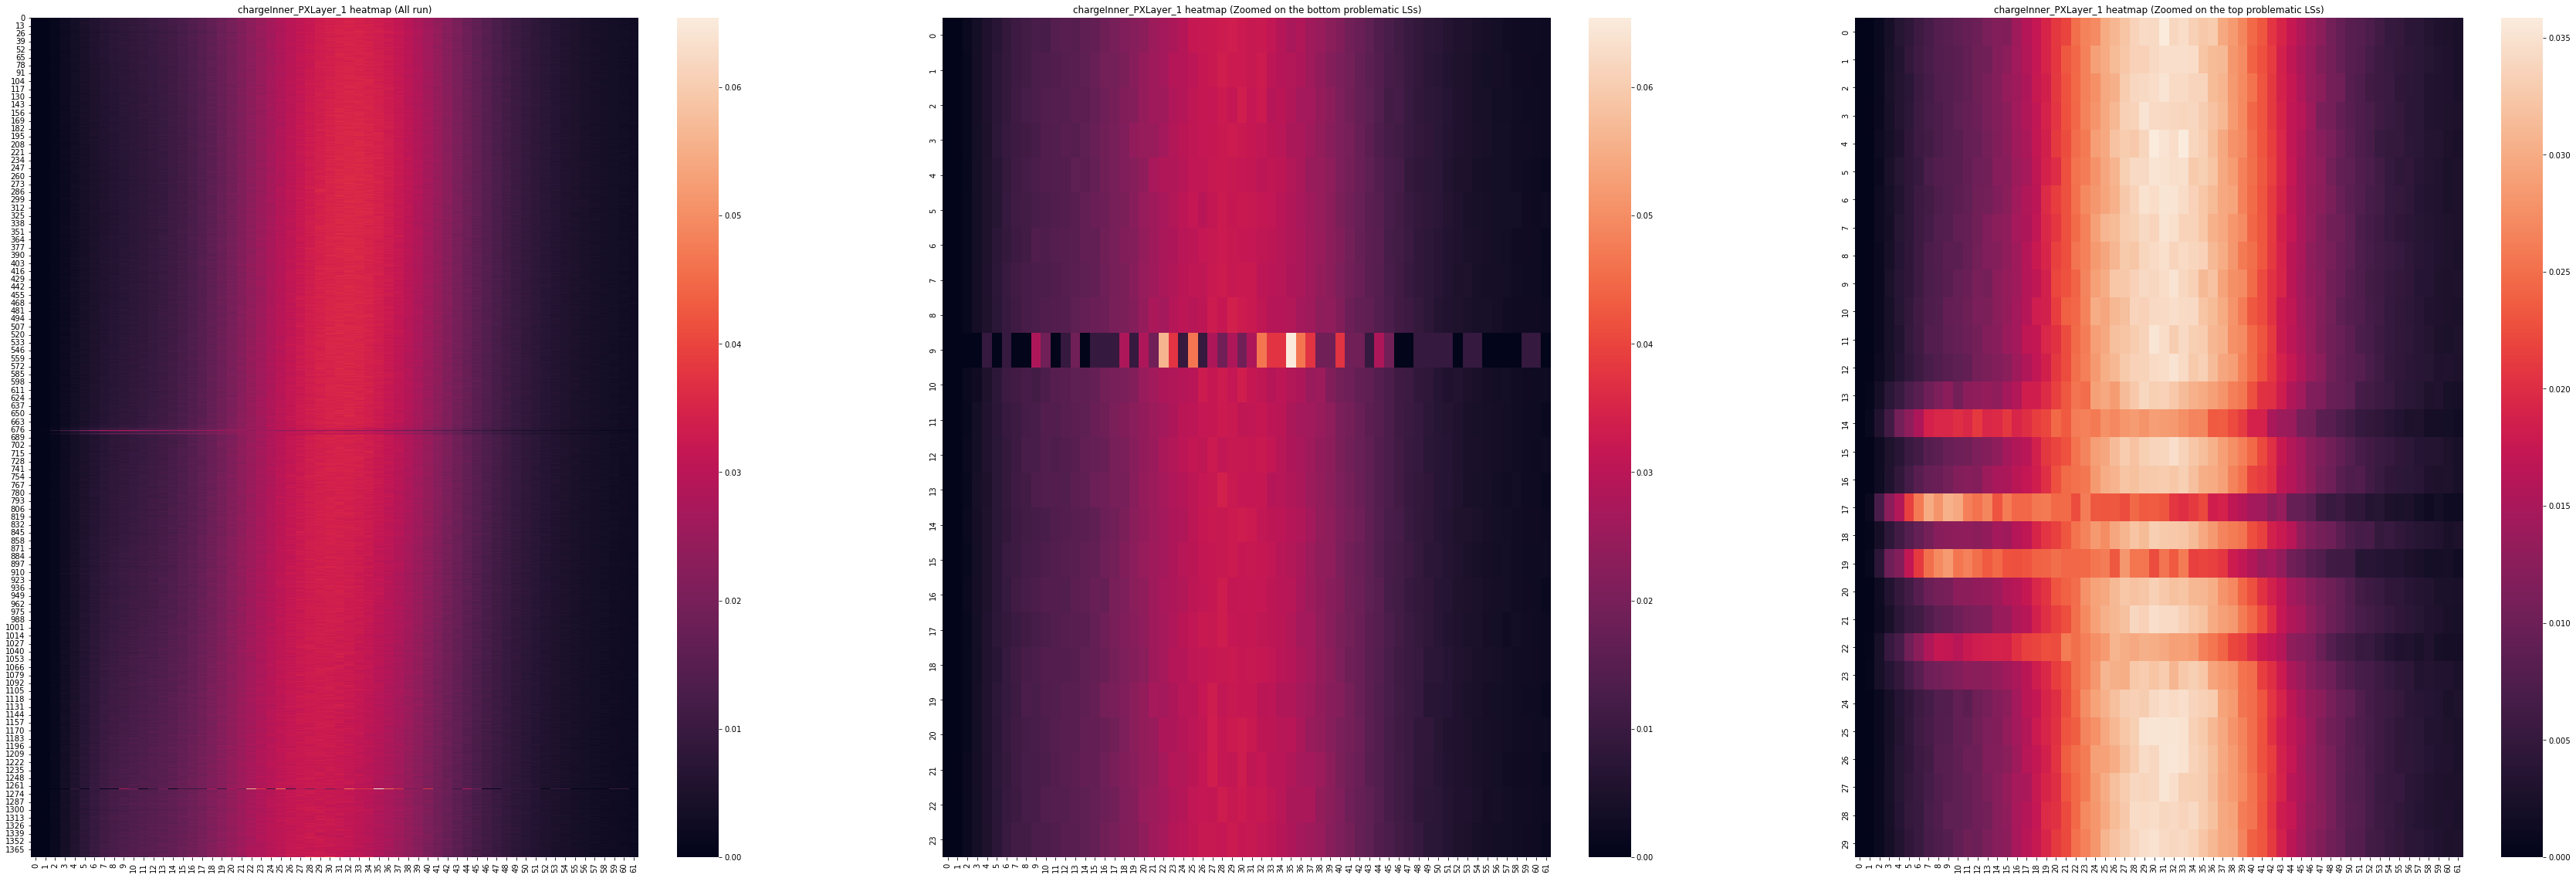

In [36]:
X_train_norm = datau.normalizeME(X_train)
fig, ax = plt.subplots(1, 3, figsize=(60,20))
ax[0] = pltu.heatmapsfig(X_train_norm, ax=ax[0], title='chargeInner_PXLayer_1 heatmap (All run)', dpi=150)
ax[1] = pltu.heatmapsfig(X_train_norm[1256:1280], ax=ax[1], title='chargeInner_PXLayer_1 heatmap (Zoomed on the bottom problematic LSs)', dpi=150)
ax[2] = pltu.heatmapsfig(X_train_norm[660:690], ax=ax[2], title='chargeInner_PXLayer_1 heatmap (Zoomed on the top problematic LSs)', dpi=150)
plt.show()

On the left hand side, we can see all of the training lumisections stacked and plotted as a heatmap. As can be seen, when the dataset is normalized, almost none of the lumisections have any real problems. However, some lumisections do appear to be problematic. In the heat map in the middle, we have zoomed in to the problematic lumisection that can be seen at around lumisection 1274. From this new perspective, it is clear that this consists of a single anomalous lumisection. Moreover, on the heat map on the right hand side, where we have zoomed on the problematic lumisections that can be seen near lumisection 676, we can observe that the number of lumisections here that have some issue is just ~8. With the proportion of good lumisections to problematic lumisection being so large, we do not have to worry about using this dataset for training.

For completeness, we look at the shape of all of the histograms together to get a sense of how they vary. Here, we have plotted all of the histograms.

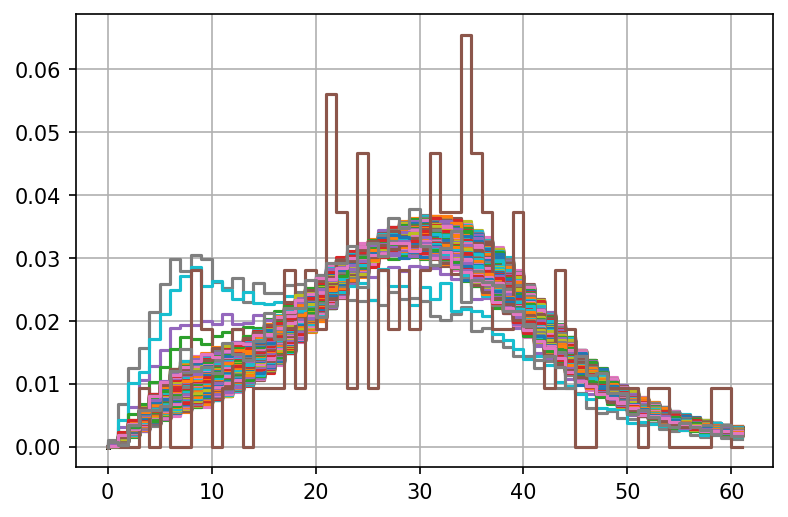

In [38]:
bins = np.arange(0, 62)
fig, ax = plt.subplots(dpi=150)
for train_hist in X_train_norm:
    ax.step(bins, train_hist)
plt.grid()

<h1><font color='blue'>Building and training the autoencoder</font></h1>

We use tensorflow to build our autoencoder. It's important to note that two versions of the autoencoder were used during testing and the one with the highest translational invariance (i.e. the one which was most succesful at reconstruction displaced histograms) was chosen. The first model constructed can be seen below. It is a simple fully connected neural network that uses LeakyReLU for all of its activation functions. 

In [62]:
class autoencoder(Model):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.encoder_layer1 = Dense(32, name='encoder_layer1')
        self.leaky_relu1 = LeakyReLU(alpha=0.01, name='lrelu1')
        self.encoder_layer2 = Dense(12, name='encoder_layer2')
        self.leaky_relu2 = LeakyReLU(alpha=0.01, name='lrelu2')
        self.encoder_layer3 = Dense(8, name='encoder_layer3')
        self.leaky_relu3 = LeakyReLU(alpha=0.01, name='lrelu3')
        
        # Decoder
        self.decoder_layer1 = Dense(12, name='decoder_layer1')
        self.leaky_relu4 = LeakyReLU(alpha=0.01, name='lrelu4')
        self.decoder_layer2 = Dense(32, name='decoder_layer2')
        self.leaky_relu5 = LeakyReLU(alpha=0.01, name='lrelu5')
        self.decoder_output = Dense(62, activation='softmax', name='decoder_output')
    
    def call(self, inputs):
        # Passing through encoder
        x = self.encoder_layer1(inputs)
        x = self.leaky_relu1(x)
        x = self.encoder_layer2(x)
        x = self.leaky_relu2(x)
        encoded = self.encoder_layer3(x)
        encoded = self.leaky_relu3(encoded)
        
        # Passing through decoder
        x = self.decoder_layer1(encoded)
        x = self.leaky_relu4(x)
        x = self.decoder_layer2(x)
        x = self.leaky_relu5(x)
        decoded = self.decoder_output(x)
        
        return decoded

As a quick test of its performance and to see how translationally invariant it is, we can use it to reconstruct a particular good run. To do this, we first train it using the reference run and then pass the target run through it. For the loss we will us the mean squared error and we will use adam as our optimizer.

In [67]:
# Alternative: Load the model from the saved file
ae_pxl1_old = tf.keras.models.load_model('models_single/nonconvAE')
ae_pxl1_old.summary()

Model: "autoencoder_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_layer1 (Dense)      multiple                  2016      
                                                                 
 lrelu1 (LeakyReLU)          multiple                  0         
                                                                 
 encoder_layer2 (Dense)      multiple                  396       
                                                                 
 lrelu2 (LeakyReLU)          multiple                  0         
                                                                 
 encoder_layer3 (Dense)      multiple                  104       
                                                                 
 lrelu3 (LeakyReLU)          multiple                  0         
                                                                 
 decoder_layer1 (Dense)      multiple               

In [ ]:
ae_pxl1_old = autoencoder()
ae_pxl1_old.compile(optimizer='adam', loss=mse)
ae_pxl1_old.build((None, 62))
ae_pxl1_old.summary()

In [64]:
# Segmenting the training data into validation and training.
X_train, X_val = train_test_split(X_train_norm, test_size=0.2)

In [60]:
print('Amount of LSs in X_train:', len(X_train), '; Amount of LSs in X_val:', len(X_val))

Amount of LSs in X_train: 1102 ; Amount of LSs in X_val: 276


Training time:
- CPU times: user 27.8 s, sys: 6.98 s, total: 34.8 s
- Wall time: 31.5 s

In [ ]:
%%time
history = ae_pxl1_old.fit(X_train, X_train, epochs=350, batch_size=128, validation_data=(X_val, X_val))
# CPU times: user 27.8 s, sys: 6.98 s, total: 34.8 s
# Wall time: 31.5 s

In [682]:
# Optional: Save the model after training it
ae_pxl1_old.save('./single_AEs/nonconvAE', save_format='tf')

INFO:tensorflow:Assets written to: ./single_AEs/nonconvAE/assets


INFO:tensorflow:Assets written to: ./single_AEs/nonconvAE/assets


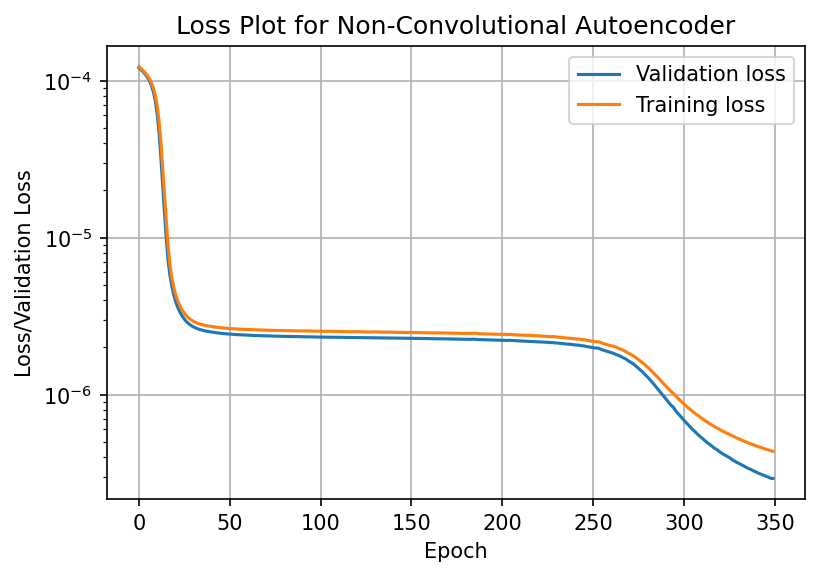

In [66]:
fig, ax = plt.subplots(dpi=150)
ax.plot(history.history['val_loss'], label='Validation loss')
ax.plot(history.history['loss'], label='Training loss')
ax.set_ylabel('Loss/Validation Loss')
ax.set_xlabel('Epoch')
ax.grid()
ax.set_yscale('log')
ax.legend()
ax.set_title('Loss Plot for Non-Convolutional Autoencoder')

plt.show()

From the loss plot we can see that after about 350 epochs, the validation and training losses begin dropping and diverging, symbolizing the point just before the model begins to overfit. For this reason, we stop training at around this point. We now test the model with a run it has never seen so that we can get a quick sense of how translationally invariant it is.

In [68]:
run_target = 297050
X_test = np.stack(megood_df[megood_df['fromrun']==run_target]['chargeInner_PXLayer_1_hist'].values)[:,:62]
X_test = datau.normalizeME(X_test)

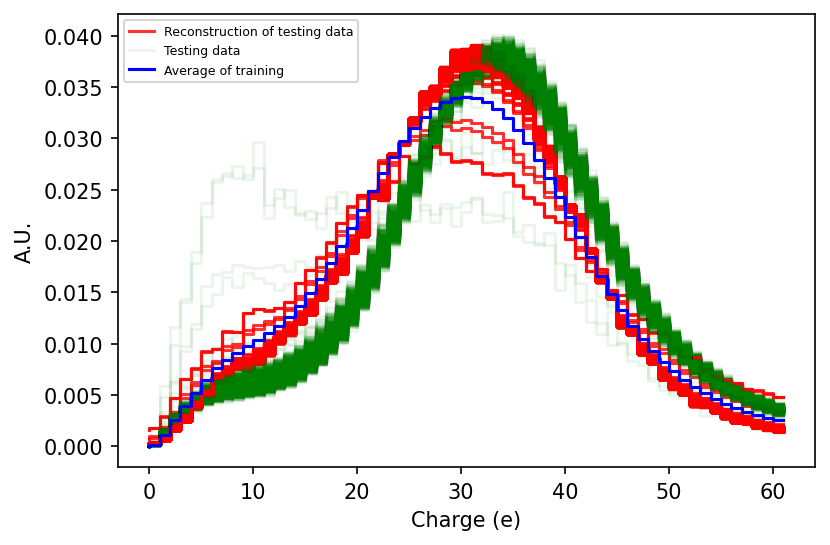

In [71]:
ae_reco = ae_pxl1_old(X_test)

fig, ax = plt.subplots(dpi=150)

for i, (reco, test) in enumerate(zip(ae_reco, X_test)):
    if i == 0:
        ax.step(bins, reco, color='red', alpha=0.8, label='Reconstruction of testing data')
        ax.step(bins, test, color='green', alpha=0.08, label='Testing data')
    ax.step(bins, reco, color='red', alpha=0.8)
    ax.step(bins, test, color='green', alpha=0.08)
ax.step(bins, X_train_norm.mean(axis=0), color='blue', alpha=1, label='Average of training')
ax.legend(loc='upper left', fontsize=6)

ax.set_xlabel('Charge (e)')
ax.set_ylabel('A.U.')

plt.show()

We can see that the model is not so translationally invariant and this will mean that the reconstruction error will tend to be large, even if the monitoring elements show now anomalies. Although the model doesn't have to be perfectly translationally invariant, its reconstructions should be able to approach the input run histograms as best as possible. In order to resolve this issue, we use a different model which has some added convolutional layers.
<!-- The problem with this is it will give the impression that there is a problem with the monitoring elements, when the only thing that is happening is that the histograms are translated with respect to the ones the model was trained on, and not that there is any real problem with the input run.  -->

In [72]:
class autoencoderconv(Model):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.leaky_relu1 = LeakyReLU(alpha=0.01, name='lrelu1')
        self.conv1 = Conv1D(32, 5, padding='same', name='conv1')
        self.leaky_relu2 = LeakyReLU(alpha=0.01, name='lrelu2')
        self.conv2 = Conv1D(32, 5, padding='same', name='conv2')
        self.leaky_relu3 = LeakyReLU(alpha=0.01, name='lrelu3')
        
        # Encoder
        self.encoder_layer1 = Dense(32, name='encoder_layer1')
        self.leaky_relu4 = LeakyReLU(alpha=0.01, name='lrelu4')
        self.encoder_layer2 = Dense(12, name='encoder_layer2')
        self.leaky_relu5 = LeakyReLU(alpha=0.01, name='lrelu5')
        self.encoder_layer3 = Dense(8, name='encoder_layer3')
        self.leaky_relu6 = LeakyReLU(alpha=0.01, name='lrelu7')
        
        # Decoder
        self.decoder_layer1 = Dense(12, name='decoder_layer1')
        self.leaky_relu7 = LeakyReLU(alpha=0.01, name='lrelu7')
        self.decoder_layer2 = Dense(32, name='decoder_layer2')
        self.leaky_relu8 = LeakyReLU(alpha=0.01, name='lrelu8')
        
        # Convolutional layers
        self.reshape = Reshape((32, 1))
        self.conv3 = Conv1D(32, 5, padding='same', name='conv3')
        self.flatten = Flatten()
        
        # Output
        self.decoder_output = Dense(62, activation='softmax', name='decoder_output')
    
    def call(self, inputs):
        # Add a dimension to input for the conv layer
        x = tf.expand_dims(inputs, axis=2)
        
        # Convolutional layer at the beginning
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.flatten(x)
        
        # Passing through encoder
        x = self.encoder_layer1(x)
        x = self.leaky_relu3(x)
        x = self.encoder_layer2(x)
        x = self.leaky_relu4(x)
        x = self.encoder_layer3(x)
        x = self.leaky_relu5(x)
        
        # Passing through decoder
        x = self.decoder_layer1(x)
        x = self.leaky_relu6(x)
        x = self.decoder_layer2(x)
        x = self.leaky_relu7(x)
        
        x = self.reshape(x)
        x = self.conv3(x)
        x = self.leaky_relu8(x)
        x = self.flatten(x)
        x = self.decoder_output(x)
        
        return x

We now instantiate, compile and train this model the same way we trained the previous model.

In [73]:
# Alternative: Load the model from the saved file
ae_pxl1 = tf.keras.models.load_model('models_single/convAE')
ae_pxl1.summary()

Model: "autoencoderconv_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lrelu1 (LeakyReLU)          multiple                  0         
                                                                 
 conv1 (Conv1D)              multiple                  192       
                                                                 
 lrelu2 (LeakyReLU)          multiple                  0         
                                                                 
 conv2 (Conv1D)              multiple                  5152      
                                                                 
 lrelu3 (LeakyReLU)          multiple                  0         
                                                                 
 encoder_layer1 (Dense)      multiple                  63520     
                                                                 
 lrelu4 (LeakyReLU)          multiple           

In [ ]:
ae_pxl1 = autoencoderconv()
ae_pxl1.compile(optimizer='adam', loss=mse)
ae_pxl1.build((None, 62))
ae_pxl1.summary()

In [605]:
# X_train_single, X_val_single = train_test_split(X_train_norm, test_size=0.2, random_state=1)

Training time:
- CPU times: user 1min 35s, sys: 15.4 s, total: 1min 51s
- Wall time: 1min 8s

In [ ]:
%%time
history = ae_pxl1.fit(X_train, X_train, epochs=350, batch_size=128, validation_data=(X_val, X_val))
# CPU times: user 1min 35s, sys: 15.4 s, total: 1min 51s
# Wall time: 1min 8s

In [ ]:
ae_pxl1.save('./single_AEs/convAE', save_format='tf')

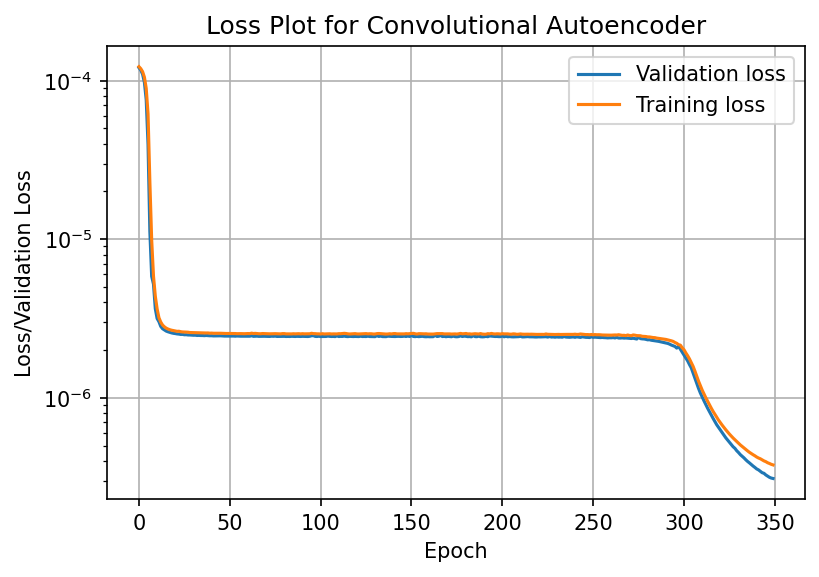

In [692]:
fig, ax = plt.subplots(dpi=150)
ax.plot(history.history['val_loss'], label='Validation loss')
ax.plot(history.history['loss'], label='Training loss')
ax.set_ylabel('Loss/Validation Loss')
ax.set_xlabel('Epoch')
ax.grid()
ax.set_yscale('log')
ax.legend()
ax.set_title('Loss Plot for Convolutional Autoencoder')

plt.show()

We see from the loss plot that the validation and training loss began to differ more near the end of the training. Although this divergence might seem significant, we need to keep in mind that the y-axis in this loss plot is logarithmic, so, in actuality, the difference in loss here is miniscule. Despite this, to avoid overfitting, the training was stopped as soon after this divergence began.

With the model trained, we test it on the same data we trained the other model on.

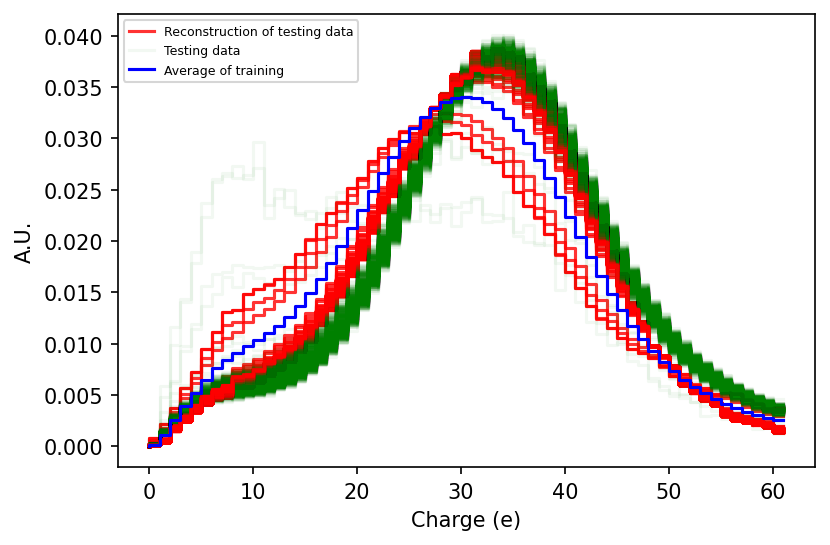

In [76]:
ae_reco = ae_pxl1(X_test)

fig, ax = plt.subplots(dpi=150)

for i, (reco, test) in enumerate(zip(ae_reco, X_test)):
    if i == 0:
        ax.step(bins, reco, color='red', alpha=0.8, label='Reconstruction of testing data')
        ax.step(bins, test, color='green', alpha=0.05, label='Testing data')
    ax.step(bins, reco, color='red', alpha=0.8)
    ax.step(bins, test, color='green', alpha=0.05)
ax.step(bins, X_train_norm.mean(axis=0), color='blue', alpha=1, label='Average of training')
ax.legend(loc='upper left', fontsize=6)

ax.set_xlabel('Charge (e)')
ax.set_ylabel('A.U.')

plt.show()

As we can see, this new model performs better in terms of translational invariance. However, it is also evident that it is not perfect as the reconstructions are not completely alligned with the test data. This, however, is acceptable: because we intend to build an autoencoder ensemble out of this base model, the model itself needs to be as simple as possible while still performing well. Moreover, while the peak of the histograms might shift and the lumisection is still considered good, a too large shift would be problematic, so our model needs to have some limitations in terms of its invariance to shifts in the histograms. To get an idea of the scale of the MSE here, we check the maximum, minimum, mean and standard deviation of the reconstructions.

In [77]:
MSE = np.array(mse(ae_reco, X_test))

print(
    '''
        Max MSE: {}
        Min MSE: {}
        Mean MSE: {}
        STD of MSE: {}
    '''.format(MSE.max(),
              MSE.min(),
              MSE.mean(),
              MSE.std()
              )
)


        Max MSE: 3.7233127189745275e-05
        Min MSE: 2.3820453335280978e-06
        Mean MSE: 4.702997925858553e-06
        STD of MSE: 2.153308072002069e-06
    


<h1><font color='blue'> Building and Training the Autoencoder Ensemble </font></h1>

We now proceed to build the autoencoder ensemble out of the second model we developed. For this, we use dictionary comprehension and the list of the monitoring element names to build a dictionary of autoencoders.

In [695]:
# Function which returns autoencode instance
def create_ae():
    return autoencoderconv()
ensemble = {name + '_AE': create_ae() for name in monitoring_elems}

The names of our autoencoders are the following:

In [554]:
list(ensemble.keys())

['chargeInner_PXLayer_1_AE',
 'chargeInner_PXLayer_2_AE',
 'chargeInner_PXLayer_3_AE',
 'chargeInner_PXLayer_4_AE',
 'chargeOuter_PXLayer_1_AE',
 'chargeOuter_PXLayer_2_AE',
 'chargeOuter_PXLayer_3_AE',
 'chargeOuter_PXLayer_4_AE',
 'charge_PXDisk_+1_AE',
 'charge_PXDisk_+2_AE',
 'charge_PXDisk_+3_AE',
 'charge_PXDisk_-1_AE',
 'charge_PXDisk_-2_AE',
 'charge_PXDisk_-3_AE',
 'num_clusters_ontrack_PXBarrel_AE',
 'num_clusters_ontrack_PXForward_AE']

We can take a look at the heatmaps for all the monitoring elements in order to get a sense of how the histograms for each look. In order to do this, we construct the training dataset in order to visualize it and then, from that, build the heatmaps.

In [79]:
Xs_train = np.array([np.stack(meRR_df[meRR_df['fromrun']==297178][me+'_hist'].values) for me in monitoring_elems])[:,:,:62]
Xs_train_norm = datau.normalizeMEs(Xs_train)

In [80]:
print('''
    Number of training datasets (one for each AE/ME type): {}
    Number of datapoints/LSs: {}
    Number of features/bins: {}
    '''.format(Xs_train_norm.shape[0],
              Xs_train_norm.shape[1],
              Xs_train_norm.shape[2])
)


    Number of training datasets (one for each AE/ME type): 16
    Number of datapoints/LSs: 1378
    Number of features/bins: 62
    


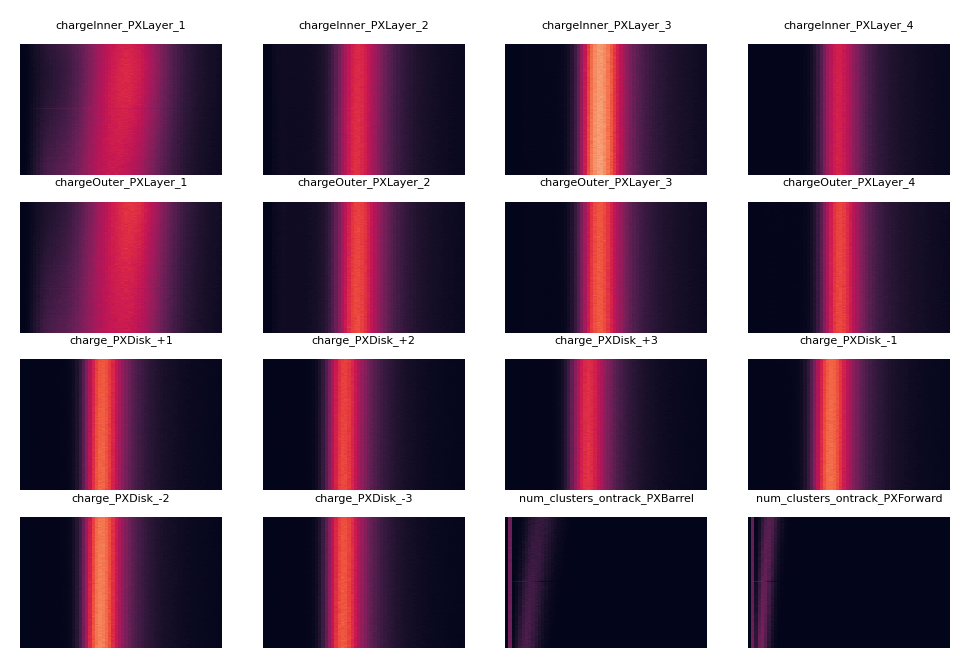

In [559]:
pltu.heatmaps(Xs_train_norm, monitoring_elems, dpi=200)

With the constructed ensemble, we compile and build all of the models and then proceed to train all of them on the same reference run we were using before. Note that each autoencoder will only train on a particular type of monitoring element (i.e. a particular type of histogram), so each of them will specialize in reconstructing only one type of histogram. In addition to this, all the model are trained using the MSE as the loss and the optimizer user is adam.

In [82]:
# Optional: Load the saved model
ensemble = {name: tf.keras.models.load_model('models_ensemble/' + 'AEConvEnsemble_'+ name) for name in monitoring_elems}

In [83]:
len(ensemble)

16

In [697]:
for me in monitoring_elems:
    ensemble[me+'_AE'].compile(optimizer='adam', loss=mse)
    ensemble[me+'_AE'].build((None,62))

In [ ]:
%%time
histories = []
for i, me in enumerate(monitoring_elems):
    X_train, X_val = train_test_split(Xs_train_norm[i], test_size=0.2, random_state=1)
    histories.append(ensemble[me+'_AE'].fit(X_train, X_train, epochs=350, batch_size=128, validation_data=(X_val, X_val)))
# CPU times: user 22min 7s, sys: 3min 38s, total: 25min 46s
# Wall time: 15min 47s

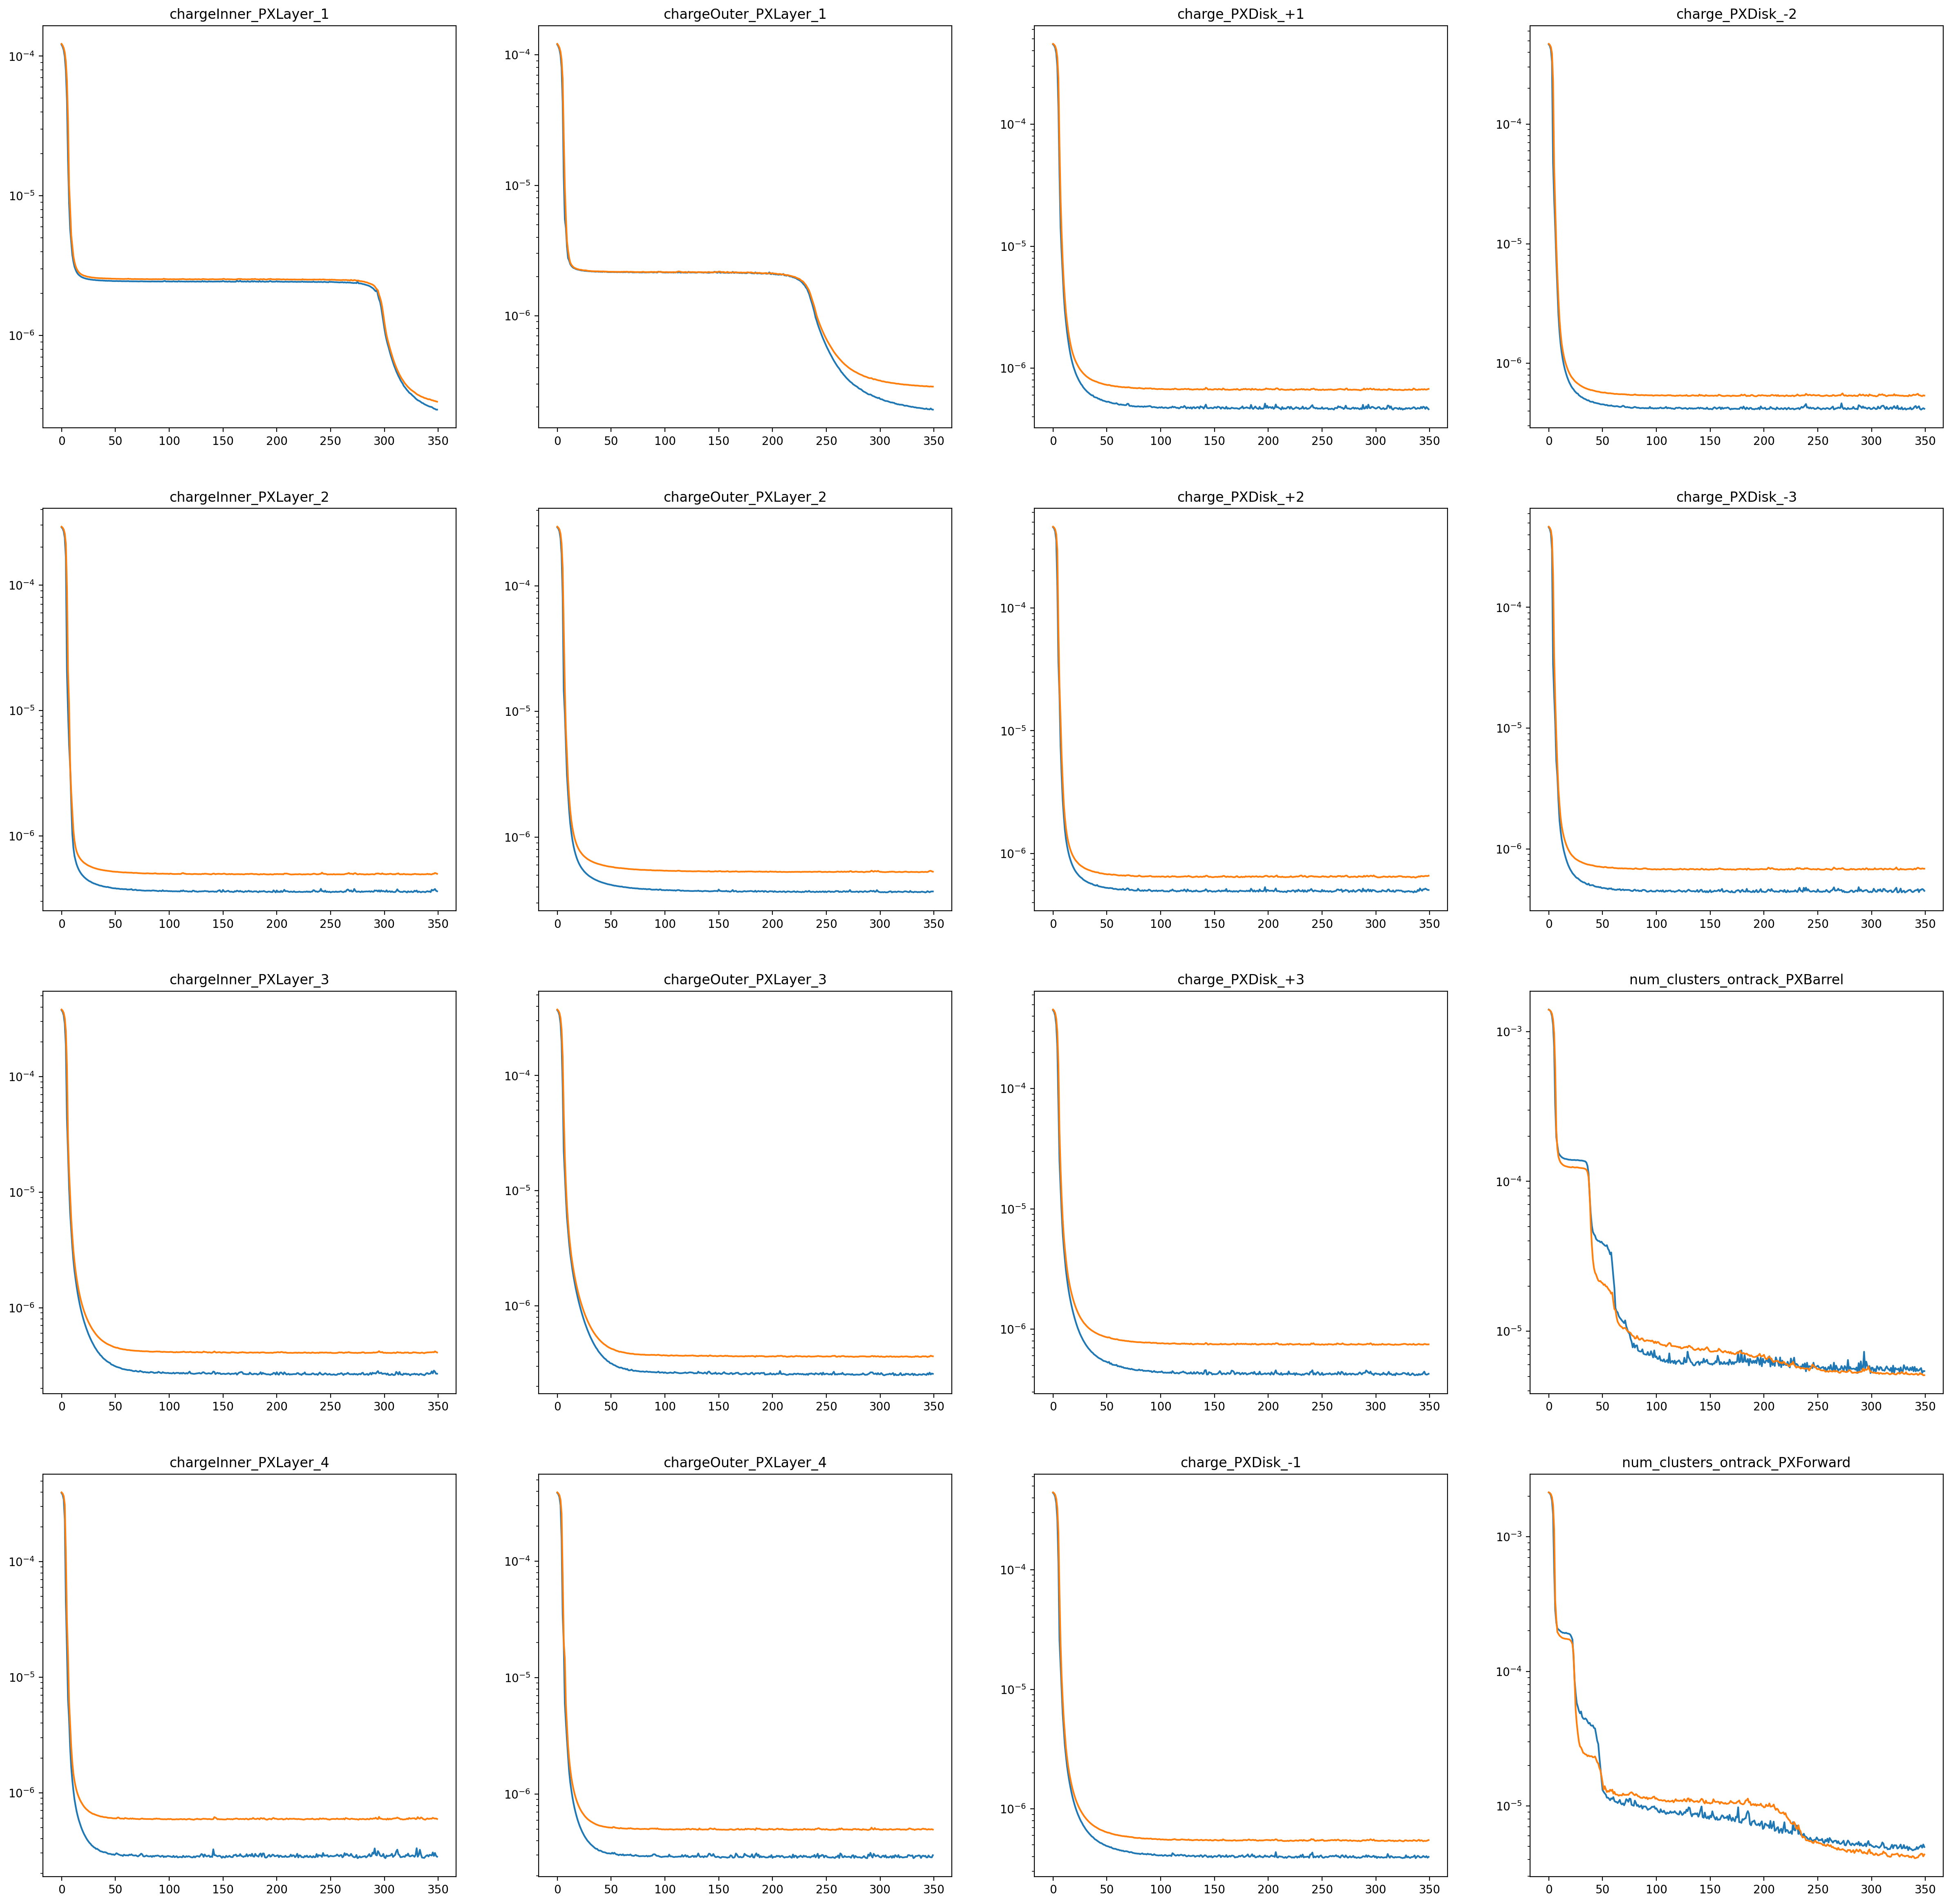

In [991]:
fig, axes = plt.subplots(4, 4, figsize=(30,30))
for i in range(0,4):
    for j in range(0,4):
        ax = axes[i, j]
        ax.plot(histories[i + 4*j].history['val_loss'], label='Validation loss')
        ax.plot(histories[i + 4*j].history['loss'], label='Training loss')
        ax.set_title(monitoring_elems[i + 4*j], fontsize=12)
        ax.set_yscale('log')
fig.set_dpi(200)
plt.show()

In [ ]:
# Optional: Saving the models
for ME_name in monitoring_elems:
    model_path = f'./models/AEConvEnsemble_{ME_name}'
    ensemble[ME_name + '_AE'].save(model_path, save_format='tf')

We now test the ensemble by having it reconstruct a good run which was certified using the reference run the model was trained on. Similar to what we did before, we first get our testing dataset, normalize it, and then run it through the trained models.

In [84]:
run_target = 297050
Xs_test = np.array([np.stack(megood_df[megood_df['fromrun']==run_target][me+'_hist'].values) for me in monitoring_elems])[:,:,:62]
Xs_test_norm = datau.normalizeMEs(Xs_test)

In [85]:
recos = []
for i, (key, AE) in enumerate(ensemble.items()):
    recos.append(AE(Xs_test_norm[i]))
recos = np.array(recos)

We make the heatmap of the original data and the reconstruction for all of the monitoring elements in order to get a general idea of how the did.

Test data...


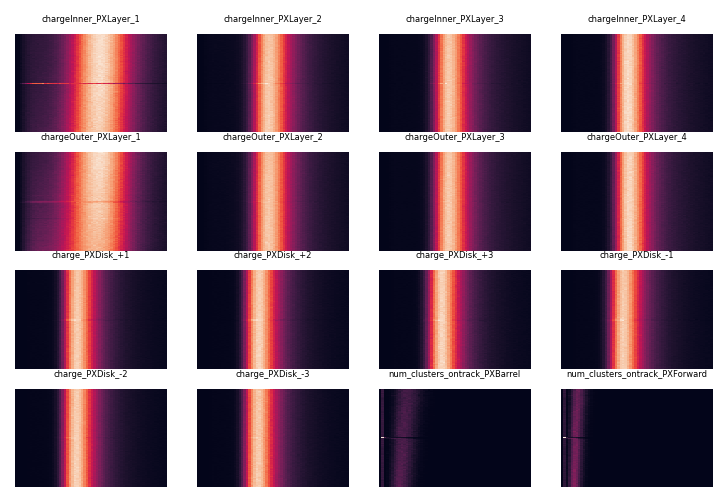


 Reconstructed data...


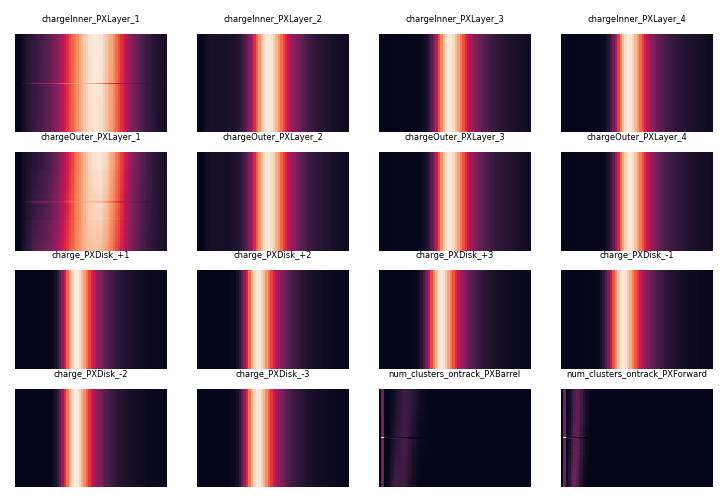

In [98]:
print('Test data...')
pltu.heatmaps(Xs_test_norm, monitoring_elems, dpi=150)

print('\n Reconstructed data...')
pltu.heatmaps(recos, monitoring_elems, dpi=150)

From these, we can see that the model did well at reconstructing the monitoring elements. To quantify how good the model did at reconstructing this good data, we can use the MSE.

In [87]:
results = {'MEname': [], 'Max MSE': [], 'Min MSE': [], 'Mean MSE': [], 'STD of MSE': []}

# Loop over the monitoring elements
for i, MEname in enumerate(monitoring_elems):
    MSE_test = np.array(mse(recos[i], X_test[i]))
    results['MEname'].append(MEname)
    results['Max MSE'].append(MSE_test.max())
    results['Min MSE'].append(MSE_test.min())
    results['Mean MSE'].append(MSE_test.mean())
    results['STD of MSE'].append(MSE_test.std())

results_df = pd.DataFrame(results)
results_df

MEname   Max MSE   Min MSE  Mean MSE    STD of MSE
0            chargeInner_PXLayer_1  0.000077  0.000012  0.000014  4.203918e-06
1            chargeInner_PXLayer_2  0.000102  0.000101  0.000101  2.688482e-08
2            chargeInner_PXLayer_3  0.000144  0.000144  0.000144  3.314014e-09
3            chargeInner_PXLayer_4  0.000191  0.000191  0.000191  8.333495e-09
4            chargeOuter_PXLayer_1  0.000099  0.000005  0.000012  7.610348e-06
5            chargeOuter_PXLayer_2  0.000105  0.000105  0.000105  3.522861e-09
6            chargeOuter_PXLayer_3  0.000143  0.000143  0.000143  6.614090e-09
7            chargeOuter_PXLayer_4  0.000171  0.000171  0.000171  1.001562e-08
8                 charge_PXDisk_+1  0.000332  0.000332  0.000332  2.660548e-08
9                 charge_PXDisk_+2  0.000339  0.000339  0.000339  6.255541e-08
10                charge_PXDisk_+3  0.000318  0.000318  0.000318  1.821532e-08
11                charge_PXDisk_-1  0.000310  0.000310  0.000310  6.645988e-09
12                charge_PXDisk_-2  0.000361  0.000361  0.000361  4.836451e-08
13                charge_PXDisk_-3  0.000360  0.000359  0.000359  5.631467e-08
14   num_clusters_ontrack_PXBarrel  0.006520  0.001716  0.001767  2.696427e-04
15  num_clusters_ontrack_PXForward  0.007553  0.002341  0.002488  3.148893e-04

Notice that the model has a higher MSE for `num_clusters_ontrack_PXBarrel` and `num_clusters_ontrack_PXForward`. We can take a look at the histograms themselves to see what is going on.

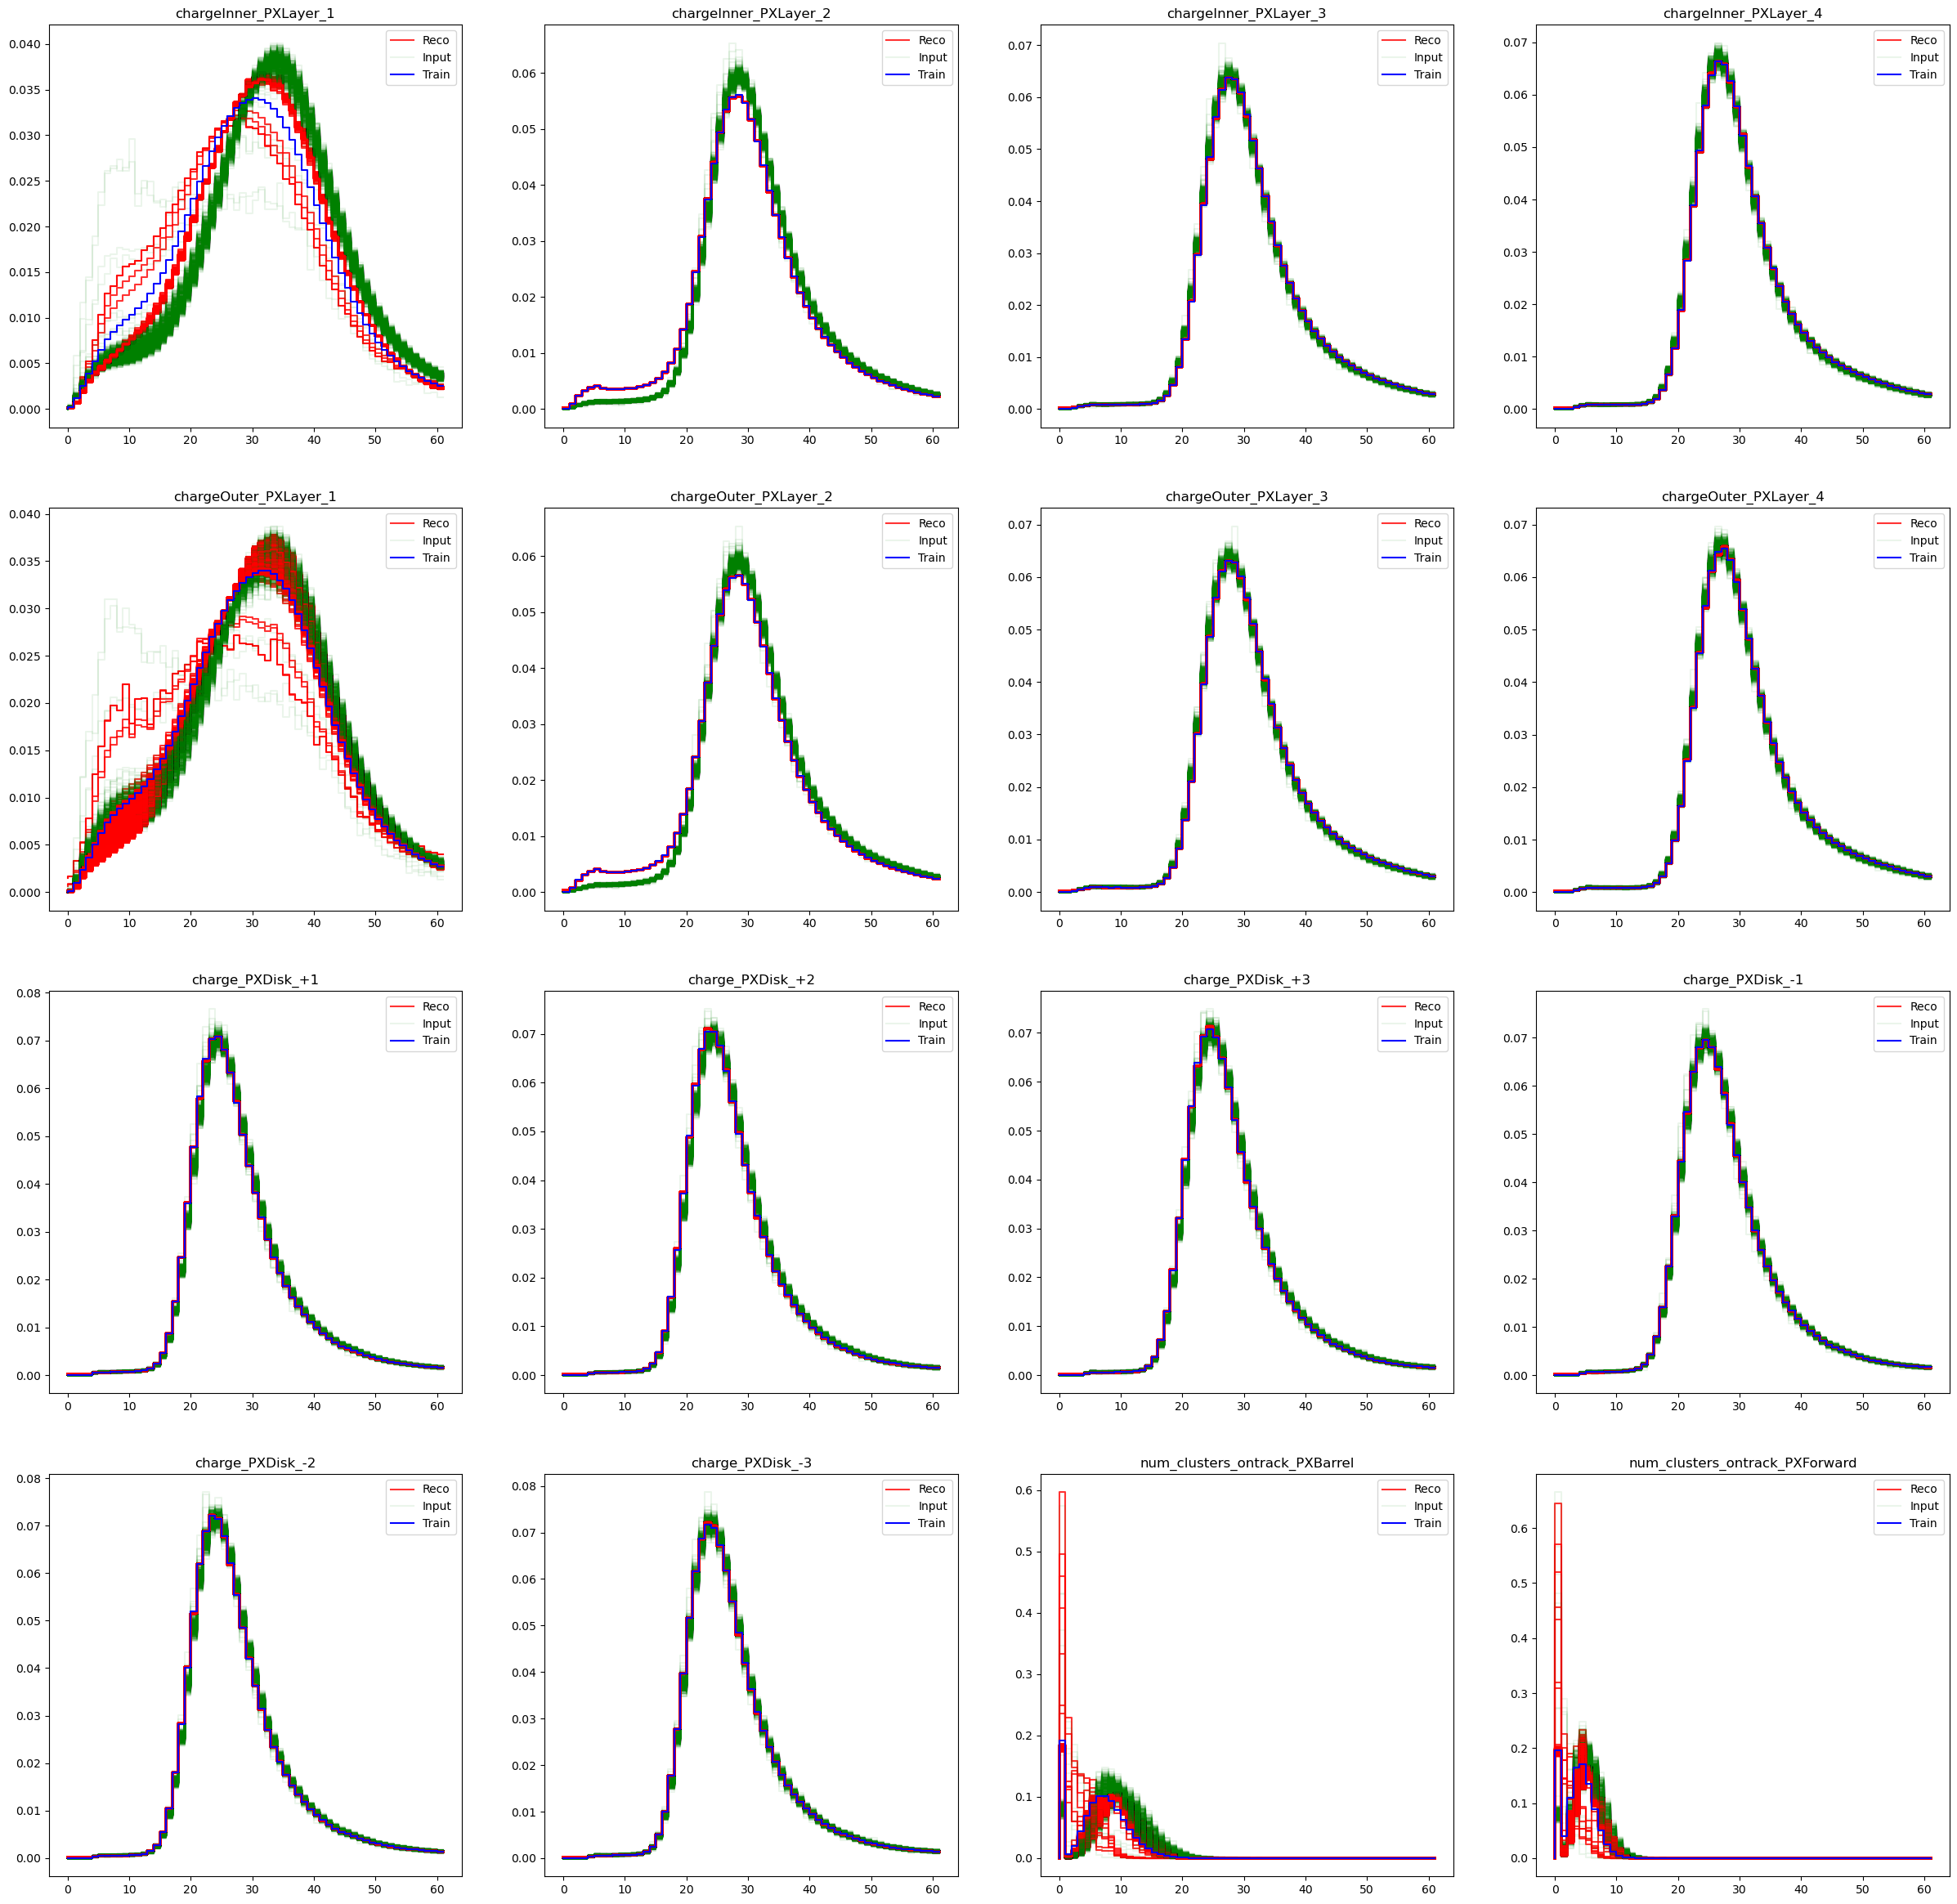

In [97]:
fig, axes = plt.subplots(4, 4, figsize=(30,30), dpi=200)
axes = axes.flatten()

for i, ax in enumerate(axes):
    reco = recos[i]
    test = Xs_test_norm[i]
    for j, histo in enumerate(reco):
        if j == 0: 
            ax.step(bins, histo, color='red', alpha=0.8, label='Reco')
            ax.step(bins, test[j], color='green', alpha=0.08, label='Input')
        ax.step(bins, histo, color='red', alpha=0.8)
        ax.step(bins, test[j], color='green', alpha=0.08)
    ax.step(bins, Xs_train_norm[i].mean(axis=0), color='blue', alpha=1, label='Train')
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(monitoring_elems[i], fontsize=12)   
plt.show()

From these plots, it is clear that the autoencoder ensemble is able to fairly accurately reconstruct all of the monitoring elements (at least the ones that do not have any abnormal behavior). From the plots for `num_clusters_ontrack_PXBarrel` and `num_clusters_ontrack_PXForward`, we can see that the relatively large MSE is likely cause by the nature of the histograms themselves, as they seem to vary considerably in shape and the underflow bin seems to vary considerably in value. Despite this, these monitoring elements were still able to be reconstructed fairly well. For `charge_InnerPXLayer_2` and `charge_OuterPXLayer_2`, the shape of the training histograms had a feature which is not present in the input data, namely a "bump" to the left side of the peak. This, however, is not problematic and was likely caused by issues with the detector which were not serious enough to impact the quality of the data.

<h1><font color='blue'>Getting MSE Threshold</font></h1>

Now that we see that the autoencoder is able to reconstruct good runs after being trained on the reference run, we proceed to get the MSE thresholds. First we create an array of bad (normalized) runs.

In [89]:
badruns_df = mebad_df[mebad_df['refrun']==297178]

In [90]:
print('Bad runs used:\n', badruns_df['fromrun'].unique())
print('Number of bad runs used:', len(badruns_df['fromrun'].unique()))

Bad runs used:
 [297047 297050 297057 297099 297101 297113 297114 297169 297179 297211
 297296 297411 297426 297431 297474 297483 297486 297503 297557 297598
 297604 297620 297659 297664 297670 297674 297678 297722 299000 299061
 299065 299067 299096 299149 299178 299185 299317 299325 299329]
Number of bad runs used: 39


In [91]:
badruns = []
for badrun in badruns_df['fromrun'].unique():
    badruns.append(np.array([np.stack(badruns_df[badruns_df['fromrun']==badrun][me+'_hist'].values) for me in monitoring_elems])[:,:,:62])

In [92]:
badruns_norm = []
for badrun in badruns:
    temp = np.array(datau.normalizeMEs(badrun))
    if temp.ndim != 0:
        badruns_norm.append(temp)

With the bad dataset now created we can take a look at the heatmaps of one of the runs just as an example

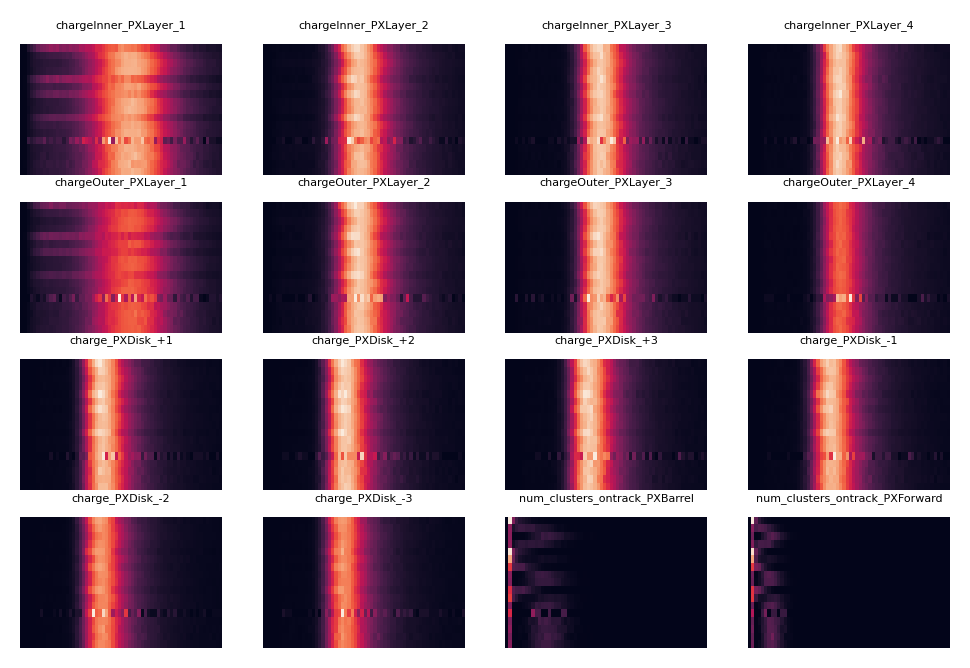

In [93]:
pltu.heatmaps(badruns_norm[1], monitoring_elems, dpi=200)

The measure of anomalousness for each particular monitoring element type of a particular run will be the average MSE (with respect to the reconstruction) across all the lumisections of the run. The threshold are found by determining these exact metrics for bad runs and taking the average of them across the available bad runs.

In [94]:
bad_recos = []
for badrun in badruns_norm:
    bad_reco = []
    for i, (key, AE) in enumerate(ensemble.items()):
        bad_reco.append(AE(badrun[i]))
    bad_recos.append(np.array(bad_reco))

Taking a look at the reconstruction heatmaps, we can see that the model was able to make a qualitively fair reconstruction of most lumisections. However, some of the obviously problematic lumisections in the original data are not present in their reconstruction, meaning that the model was not able to faithfully reconstruct those lumisections.

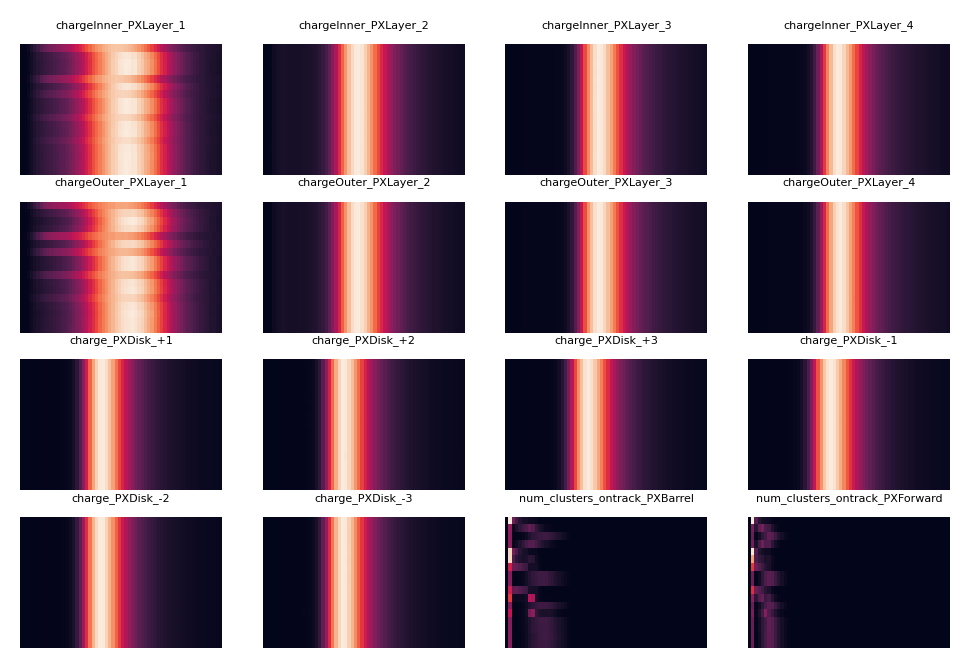

In [95]:
pltu.heatmaps(bad_recos[1], monitoring_elems, dpi=200)

Taking a look at the actual histograms...

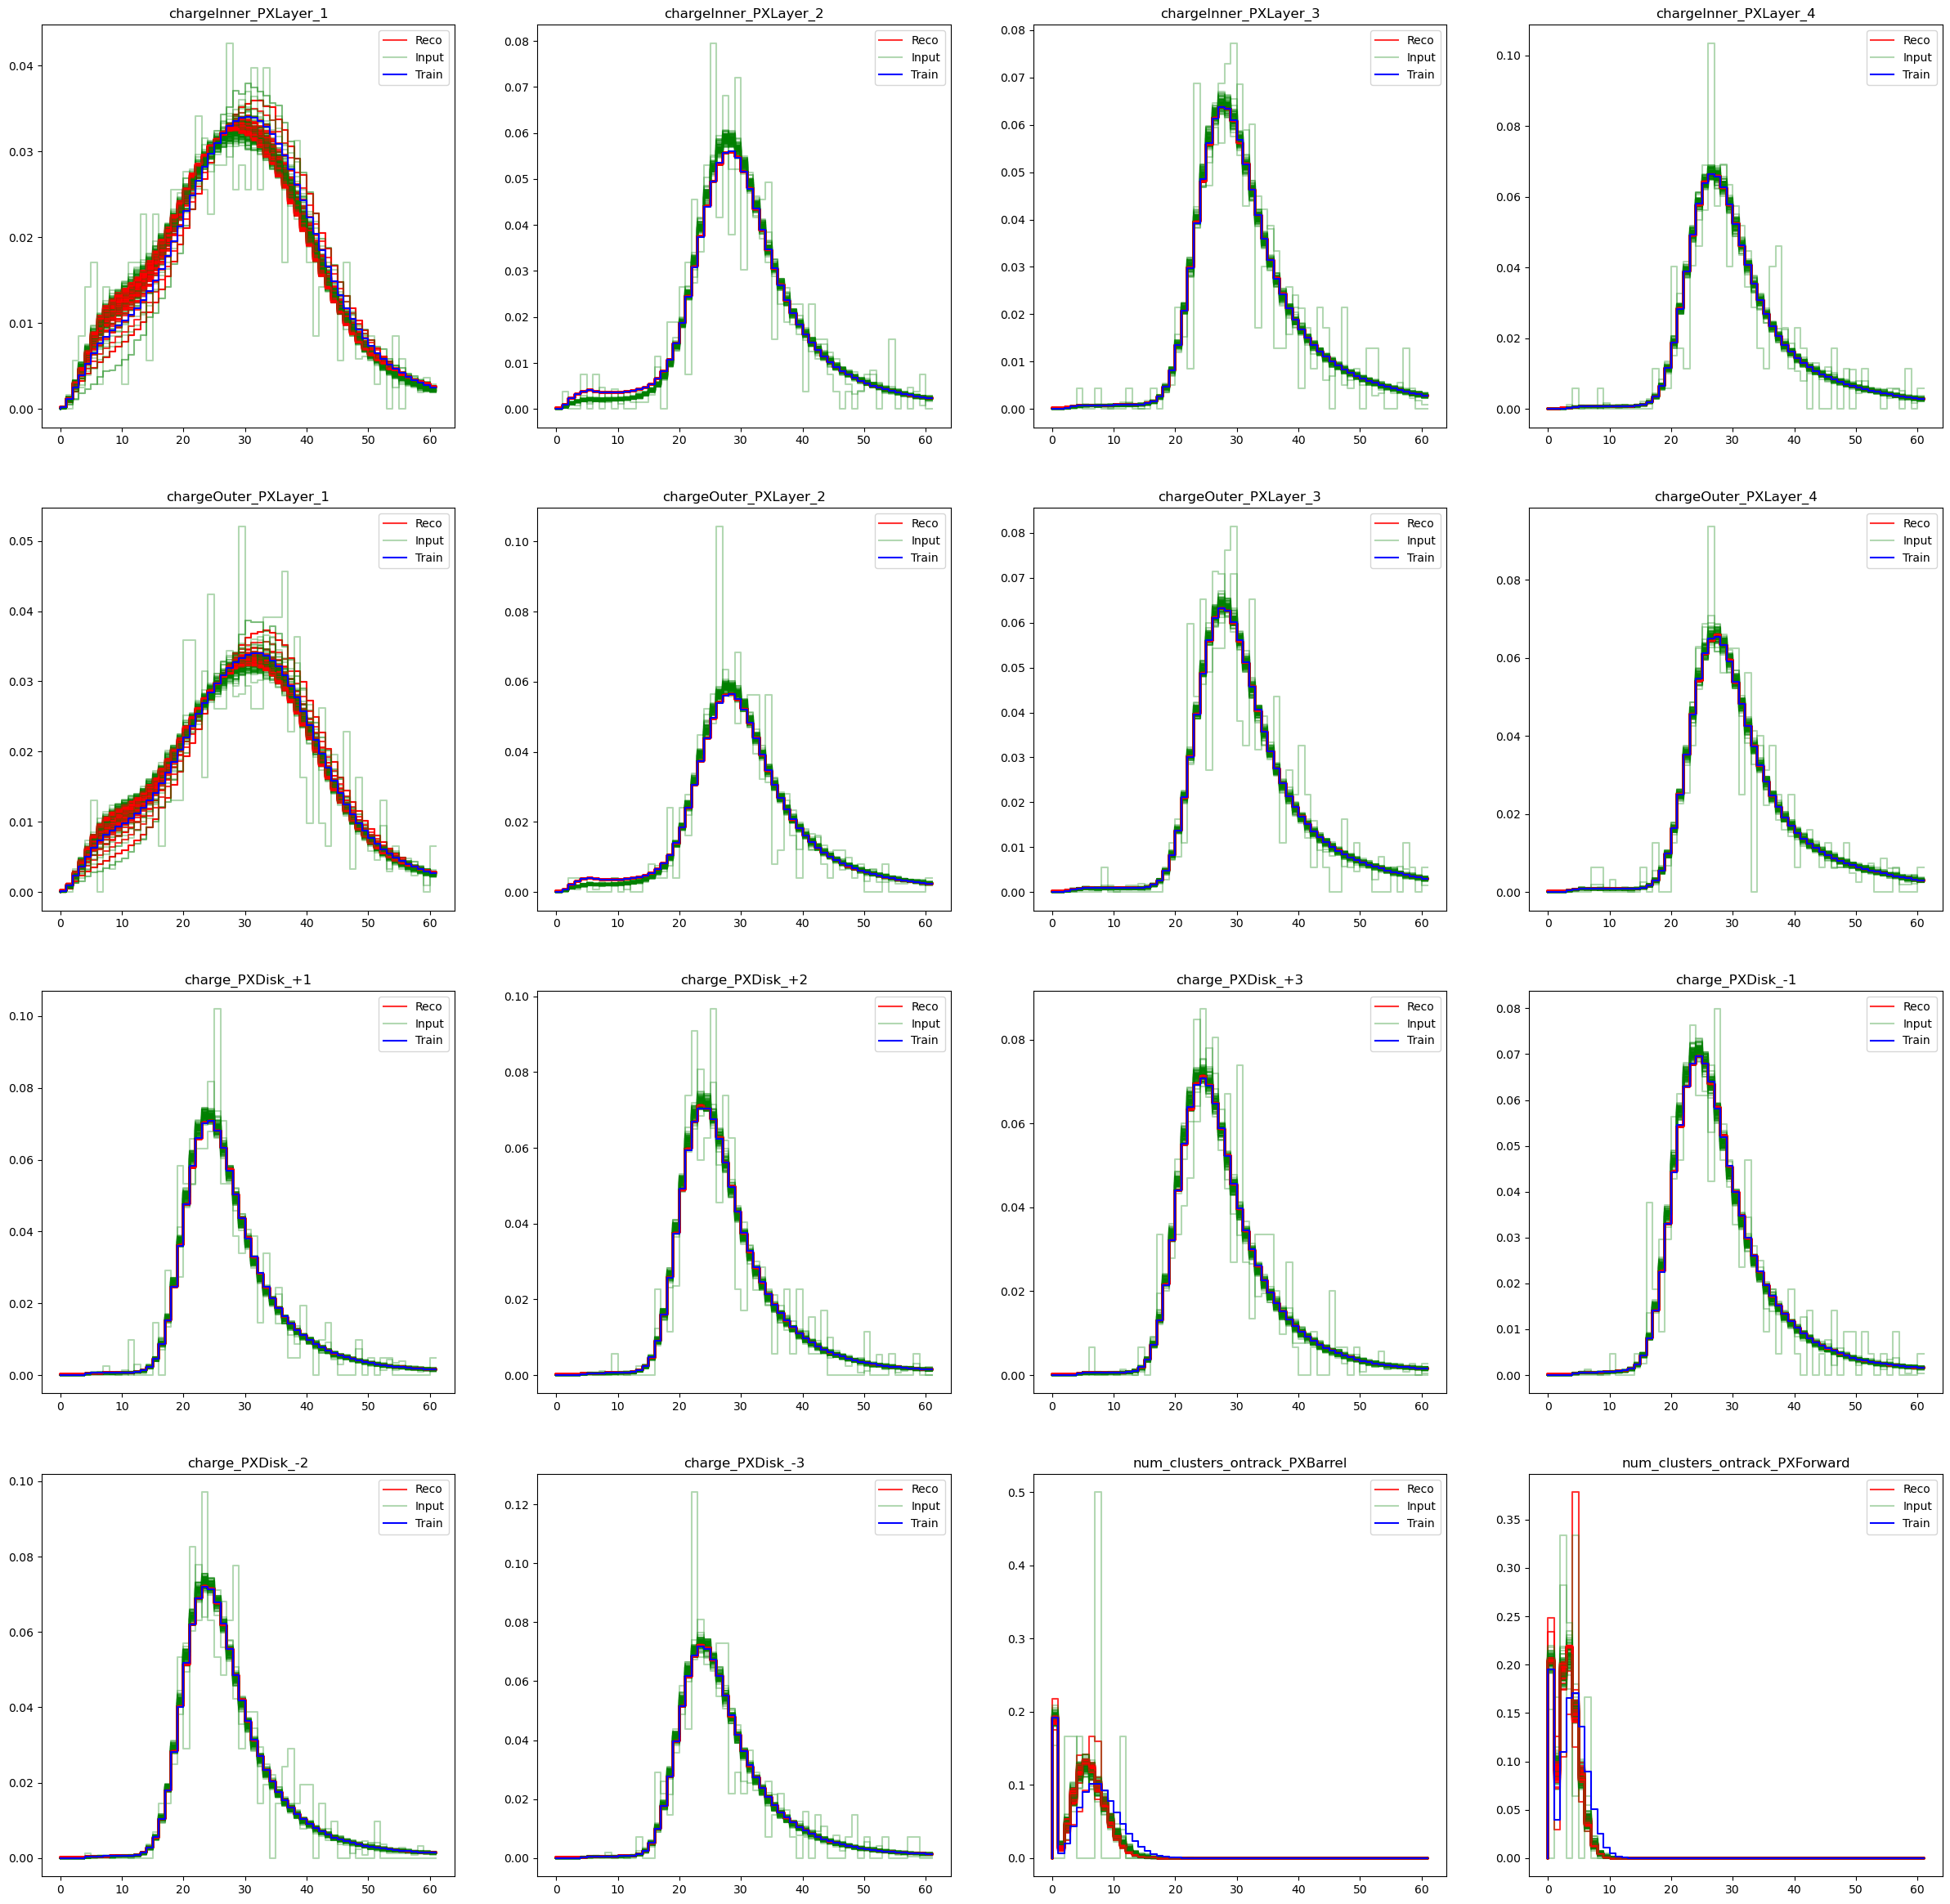

In [96]:
fig, axes = plt.subplots(4, 4, figsize=(30,30), dpi=100)
axes = axes.flatten()

for i, ax in enumerate(axes):
    reco = bad_recos[3][i]
    test = badruns_norm[3][i]
    for j, histo in enumerate(reco):
        if j == 0: 
            ax.step(bins, histo, color='red', alpha=0.8, label='Reco')
            ax.step(bins, test[j], color='green', alpha=0.3, label='Input')
        ax.step(bins, histo, color='red', alpha=0.8)
        ax.step(bins, test[j], color='green', alpha=0.3)
    ax.step(bins, Xs_train_norm[i].mean(axis=0), color='blue', alpha=1, label='Train')
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(monitoring_elems[i], fontsize=12)   
plt.show()

With the reconstructions, we can now get the MSE.

In [99]:
# For each histogram of each ME type of each run, find the mean MSE
runMSEs = []
for bad_reco, badrun in zip(bad_recos, badruns_norm):
    runMSE = []
    for i in range(len(monitoring_elems)):
        runMEMSE = mse(bad_reco[i], badrun[i])
        runMEmeanMSE = reduce_mean(runMEMSE).numpy().item()
        runMSE.append(np.array(runMEmeanMSE))
    runMSEs.append(np.array(runMSE))
runMSEs = np.array(runMSEs)

This then gives us the final thresholds.

In [100]:
ME_thresholds = np.array(runMSEs).mean(axis=0)
print(ME_thresholds)

[2.18462230e-05 1.94887171e-05 1.07492532e-05 9.83301978e-06
 1.97903398e-05 1.98243423e-05 1.08008452e-05 1.10499067e-05
 1.72083867e-05 1.78486584e-05 1.82221827e-05 1.78925987e-05
 1.50416032e-05 1.48688166e-05 2.79218024e-04 3.00631403e-04]


<h1><font color='blue'>Good Run Evaluation & Analysis</font></h1>

We start by construction the evaluation dataset, i.e. a dataset containing the monitoring elements for runs which were certified as good and which have as reference run the same run that was used to train the autoencoder ensemble.

In [101]:
eval_df = megood_df[megood_df['refrun'] == 297178]
eval_runnum = eval_df['fromrun'].unique()

The available runs are the following

In [102]:
eval_runnum

array([297050, 297057, 297099, 297101, 297113, 297114, 297175, 297177,
       297215, 297218, 297225, 297296, 297411, 297426, 297431, 297434,
       297468, 297483, 297486, 297503, 297557, 297604, 297620, 297670,
       297674, 297722, 298997, 299000, 299061, 299065, 299067, 299096,
       299149, 299178, 299184, 299185, 299327, 299329])

In [103]:
evalruns = []
for evalrun in eval_runnum:
    evalruns.append(np.array([np.stack(eval_df[eval_df['fromrun']==evalrun][me+'_hist'].values) for me in monitoring_elems])[:,:,:62])
    
evalruns_norm = []
for evalrun in evalruns:
    temp = np.array(datau.normalizeMEs(evalrun, filterruns=False, emptyto0=True))
    evalruns_norm.append(temp)

As an example of what this data looks like, we can plot the heatmaps for the first available run which is 297050.

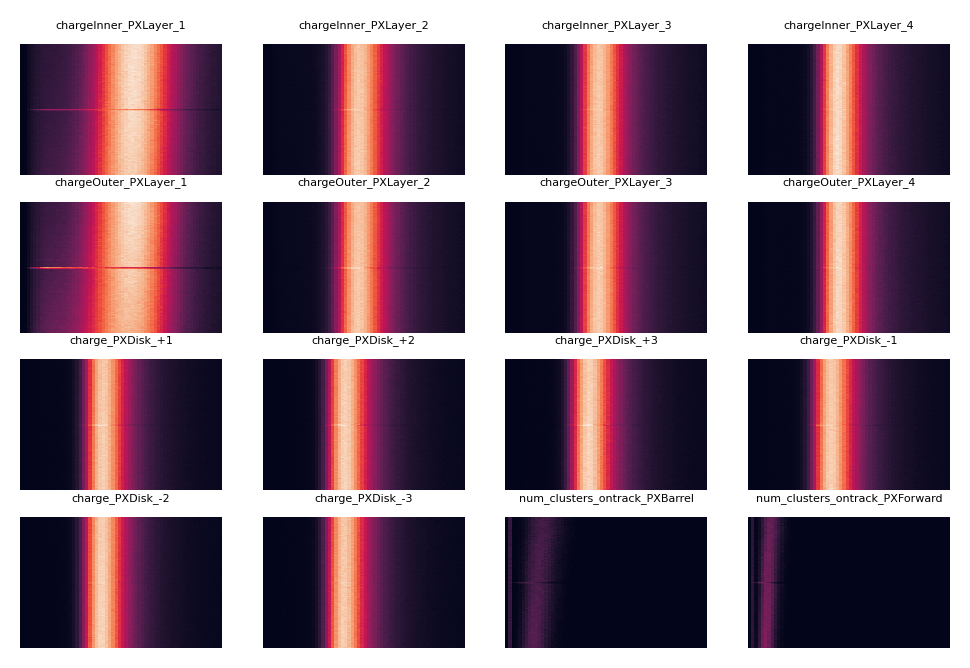

In [734]:
pltu.heatmaps(evalruns_norm[0], monitoring_elems, dpi=200)

We feed all of these runs into our autoencoder. As an example of the output, the heatmaps for run 297050 are shown.

In [104]:
eval_recos = []
for evalrun in evalruns_norm:
    eval_reco = []
    for i, (key, AE) in enumerate(ensemble.items()):
        eval_reco.append(AE(evalrun[i]))
    eval_recos.append(np.array(eval_reco))

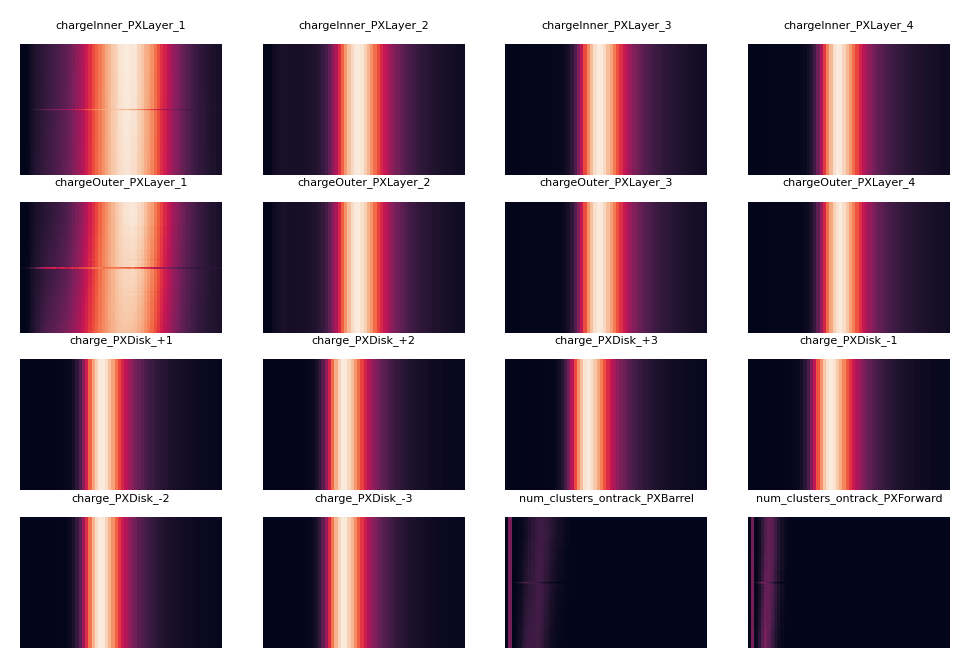

In [736]:
pltu.heatmaps(eval_recos[0], monitoring_elems, dpi=200)

With the reconstructions, we now find the MSE for all of them and proceed to compare the value for each of the monitoring elements for each LS to the corresponding MSE threshold. With these results, we compute the accuracy for each lumisection. By accuracy, we mean number of lumisections for a particular monitoring element for which the autoencoder reconstruction MSE fell below the threshold (i.e. considered "good" by the autoencoder), divided by the number of lumisections in the run. Mathematically, this would be
$$
\text{Accuracy}_i(\text{ME}) = \frac{\text{Count of LSs with MSE } < \text{ Threshold in run }i}{\text{Total Count of LSs certified as good in run }i}
$$

To have an overarching numerical value roughly representing the accuracy of the certficiations made by shifters as measured with an autoencoder ensemble, we define a quantity called "goodness" which is defined as follow

$$
\text{Goodness}(\text{run }i) = \left<\text{Accuracy}_i\right>_{\text{ME}}
$$

In [105]:
accuracy_scores = []
for i, reco in enumerate(eval_recos):
    numLSs = reco.shape[1]
    accuracy_scores.append((mse(eval_recos[i], evalruns_norm[i]) < ME_thresholds.reshape(-1, 1)).numpy().sum(axis=1) / numLSs)
accuracy_scores = np.array(accuracy_scores)

In [106]:
acc_df = pd.DataFrame(accuracy_scores, columns=monitoring_elems)
acc_df.insert(0, 'fromrun', eval_runnum)
acc_df.set_index('fromrun', inplace=True)
acc_df.insert(0, 'meanacc', acc_df.T.describe().loc['mean'])
acc_df.insert(0, 'above90', (acc_df.loc[:, 'chargeInner_PXLayer_1':] > 0.9).sum(axis=1))
acc_df.insert(0, 'fracabove90', (acc_df.loc[:, 'chargeInner_PXLayer_1':] > 0.9).sum(axis=1)/16)

In [108]:
acc_df

fracabove90  above90   meanacc  chargeInner_PXLayer_1  \
fromrun                                                          
297050        1.0000       16  0.994799               0.997179   
297057        1.0000       16  0.993557               0.985109   
297099        0.8750       14  0.875000               1.000000   
297101        0.9375       15  0.943344               0.996700   
297113        1.0000       16  0.994141               1.000000   
297114        1.0000       16  1.000000               1.000000   
297175        1.0000       16  1.000000               1.000000   
297177        1.0000       16  1.000000               1.000000   
297215        0.8750       14  0.875000               1.000000   
297218        0.8750       14  0.933333               1.000000   
297225        1.0000       16  0.995000               1.000000   
297296        1.0000       16  1.000000               1.000000   
297411        1.0000       16  0.999380               1.000000   
297426        1.0000       16  1.000000               1.000000   
297431        1.0000       16  1.000000               1.000000   
297434        1.0000       16  1.000000               1.000000   
297468        1.0000       16  0.999155               1.000000   
297483        1.0000       16  0.989955               0.994048   
297486        1.0000       16  1.000000               1.000000   
297503        1.0000       16  1.000000               1.000000   
297557        1.0000       16  0.993521               0.987805   
297604        0.7500       12  0.862307               1.000000   
297620        1.0000       16  0.987633               0.946996   
297670        0.8750       14  0.875000               0.000000   
297674        0.8125       13  0.852730               0.183908   
297722        0.7500       12  0.800523               0.006969   
298997        0.7500       12  0.759309               0.000000   
299000        0.6875       11  0.726351               0.000000   
299061        0.6875       11  0.731167               0.000000   
299065        0.6250       10  0.619874               0.000000   
299067        0.3750        6  0.482707               0.000000   
299096        0.6875       11  0.742839               0.000000   
299149        0.6875       11  0.711758               0.000000   
299178        0.6875       11  0.711914               0.000000   
299184        0.6250       10  0.637950               0.000000   
299185        0.5625        9  0.586979               0.000000   
299327        0.5000        8  0.593297               0.000000   
299329        0.5000        8  0.559593               0.000000   

         chargeInner_PXLayer_2  chargeInner_PXLayer_3  chargeInner_PXLayer_4  \
fromrun                                                                        
297050                1.000000               1.000000               1.000000   
297057                1.000000               1.000000               1.000000   
297099                1.000000               1.000000               1.000000   
297101                1.000000               1.000000               1.000000   
297113                1.000000               1.000000               1.000000   
297114                1.000000               1.000000               1.000000   
297175                1.000000               1.000000               1.000000   
297177                1.000000               1.000000               1.000000   
297215                1.000000               1.000000               1.000000   
297218                1.000000               1.000000               1.000000   
297225                1.000000               1.000000               1.000000   
297296                1.000000               1.000000               1.000000   
297411                1.000000               1.000000               1.000000   
297426                1.000000               1.000000               1.000000   
297431                1.000000               1.000000               1.000000   
297434  

We also make a histogram showing the amount of monitoring elements which have an accuracy score above 90%

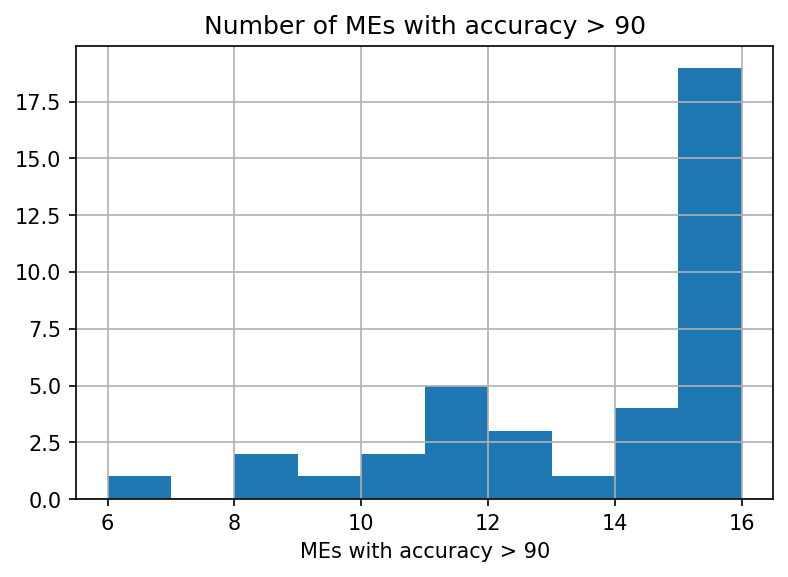

In [112]:
fig, axes = plt.subplots(dpi=150)
axes = acc_df['above90'].hist()
axes.set_xlabel('MEs with accuracy > 90')
axes.set_title('Number of MEs with accuracy > 90')
plt.show()

With these results, we can make some plots to visualize the goodness of each of the runs.

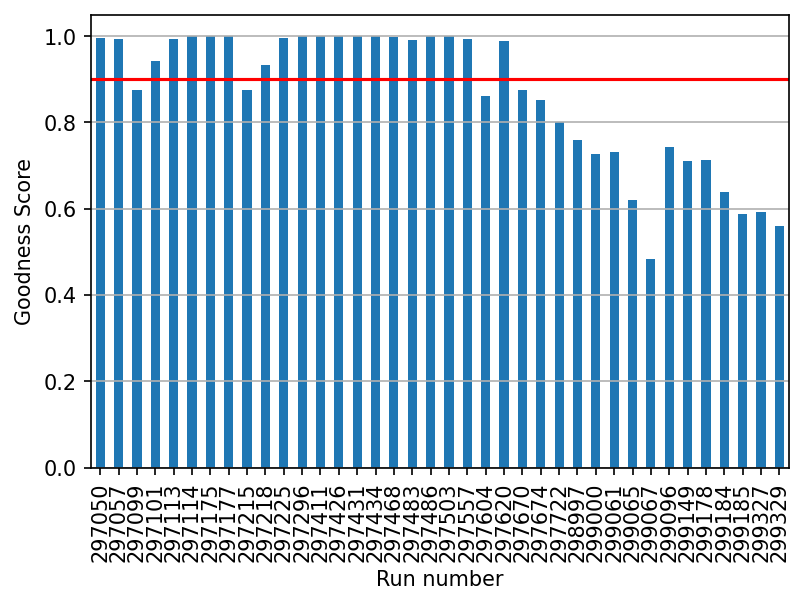

In [111]:
fig, axes = plt.subplots(dpi=150)
axes = acc_df['meanacc'].plot(kind='bar')
axes.set_xlabel('Run number')
axes.set_ylabel('Goodness Score')
axes.plot(range(-10, 60), [0.9]*70, color='r')
axes.grid(axis='y')
plt.show()

In [109]:
# fig, axes = plt.subplots(dpi=150)
# axes = acc_df['fracabove90'].plot(kind='bar')
# axes.set_xlabel('Run number')
# axes.set_ylabel('Fraction of MEs with accuracy above 90%')
# axes.plot(range(-10, 60), [0.9]*70, color='r')
# axes.grid(axis='y')
# plt.show()

We can see that for runs which are farther away from the reference run the models were trained on, the worse the goodness score is. If we look at the histograms and the reconstructions, we can see that this is not due to there being an actual problem with these runs, but likely rather with the limitations of the autoencoder and the limited window of applicability of a reference run due to changing data-collection conditions.

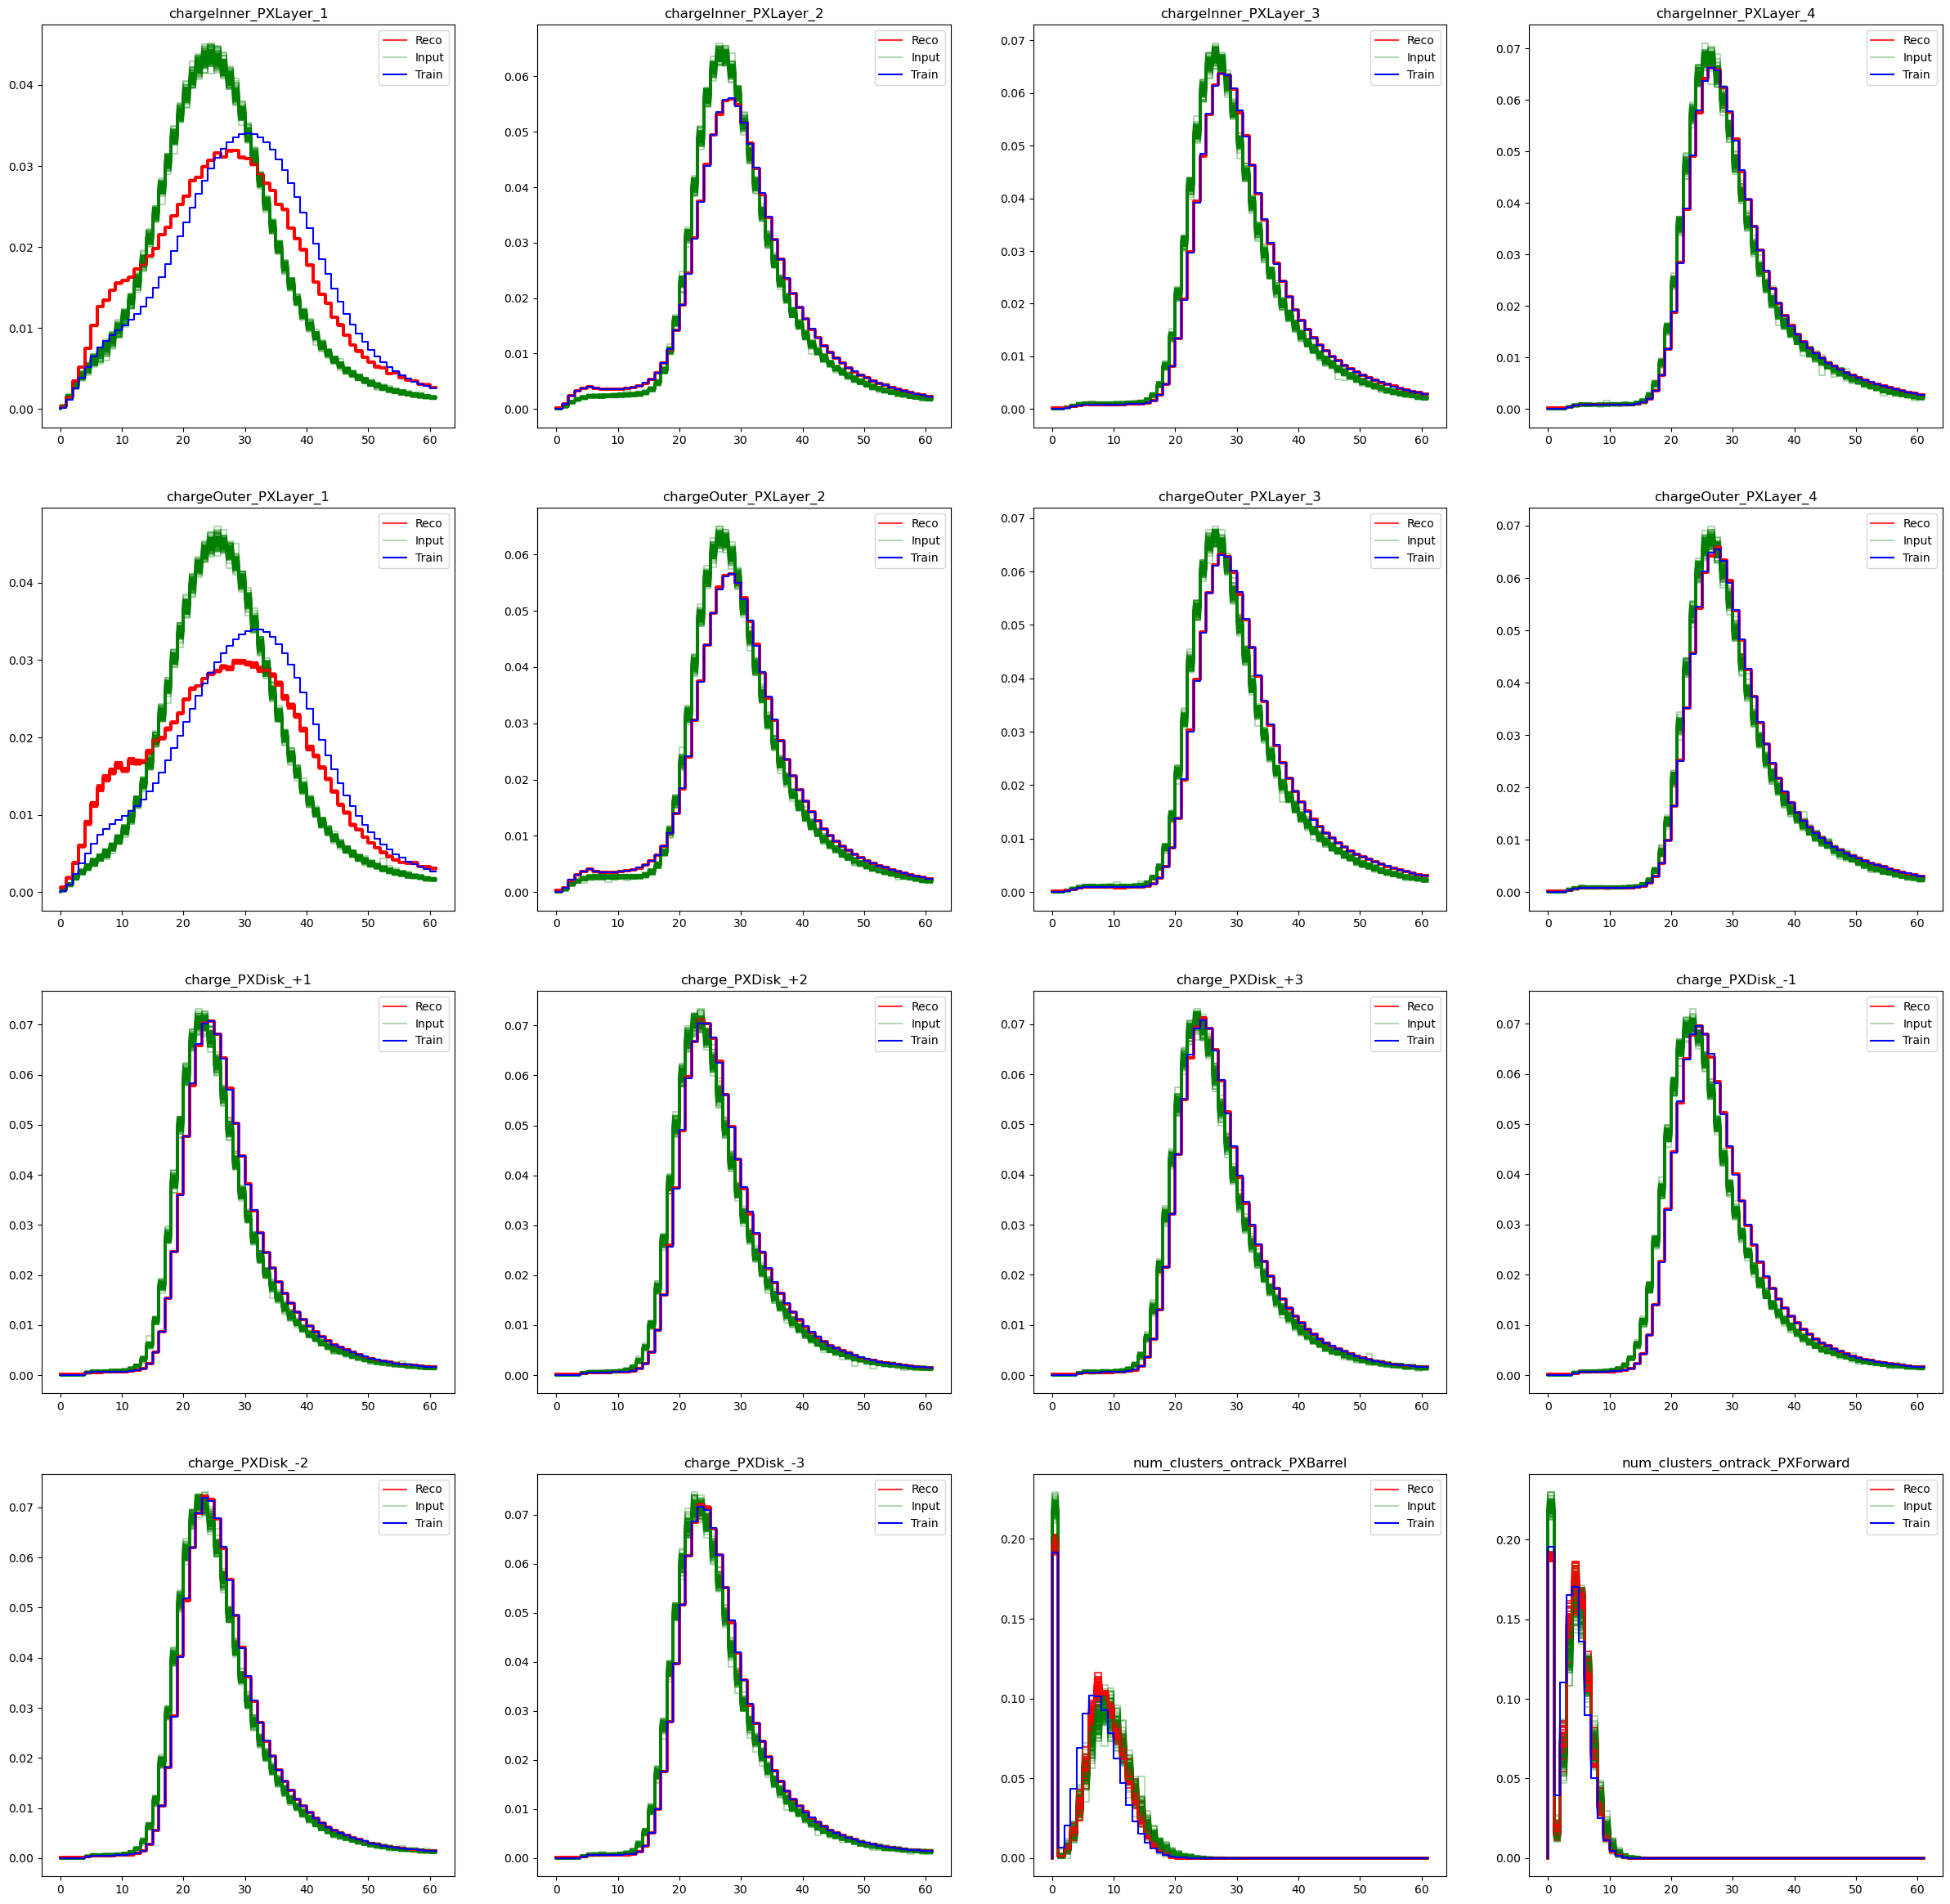

In [119]:
pltu.plotallMEs(eval_recos, evalruns_norm, Xs_train_norm, monitoring_elems, k=-1, dpi=100)

If we want to evaluate the runs in a meaningful way, we can therefore only consider runs which are close to the reference run. For example, run 297050, we have the following histograms.

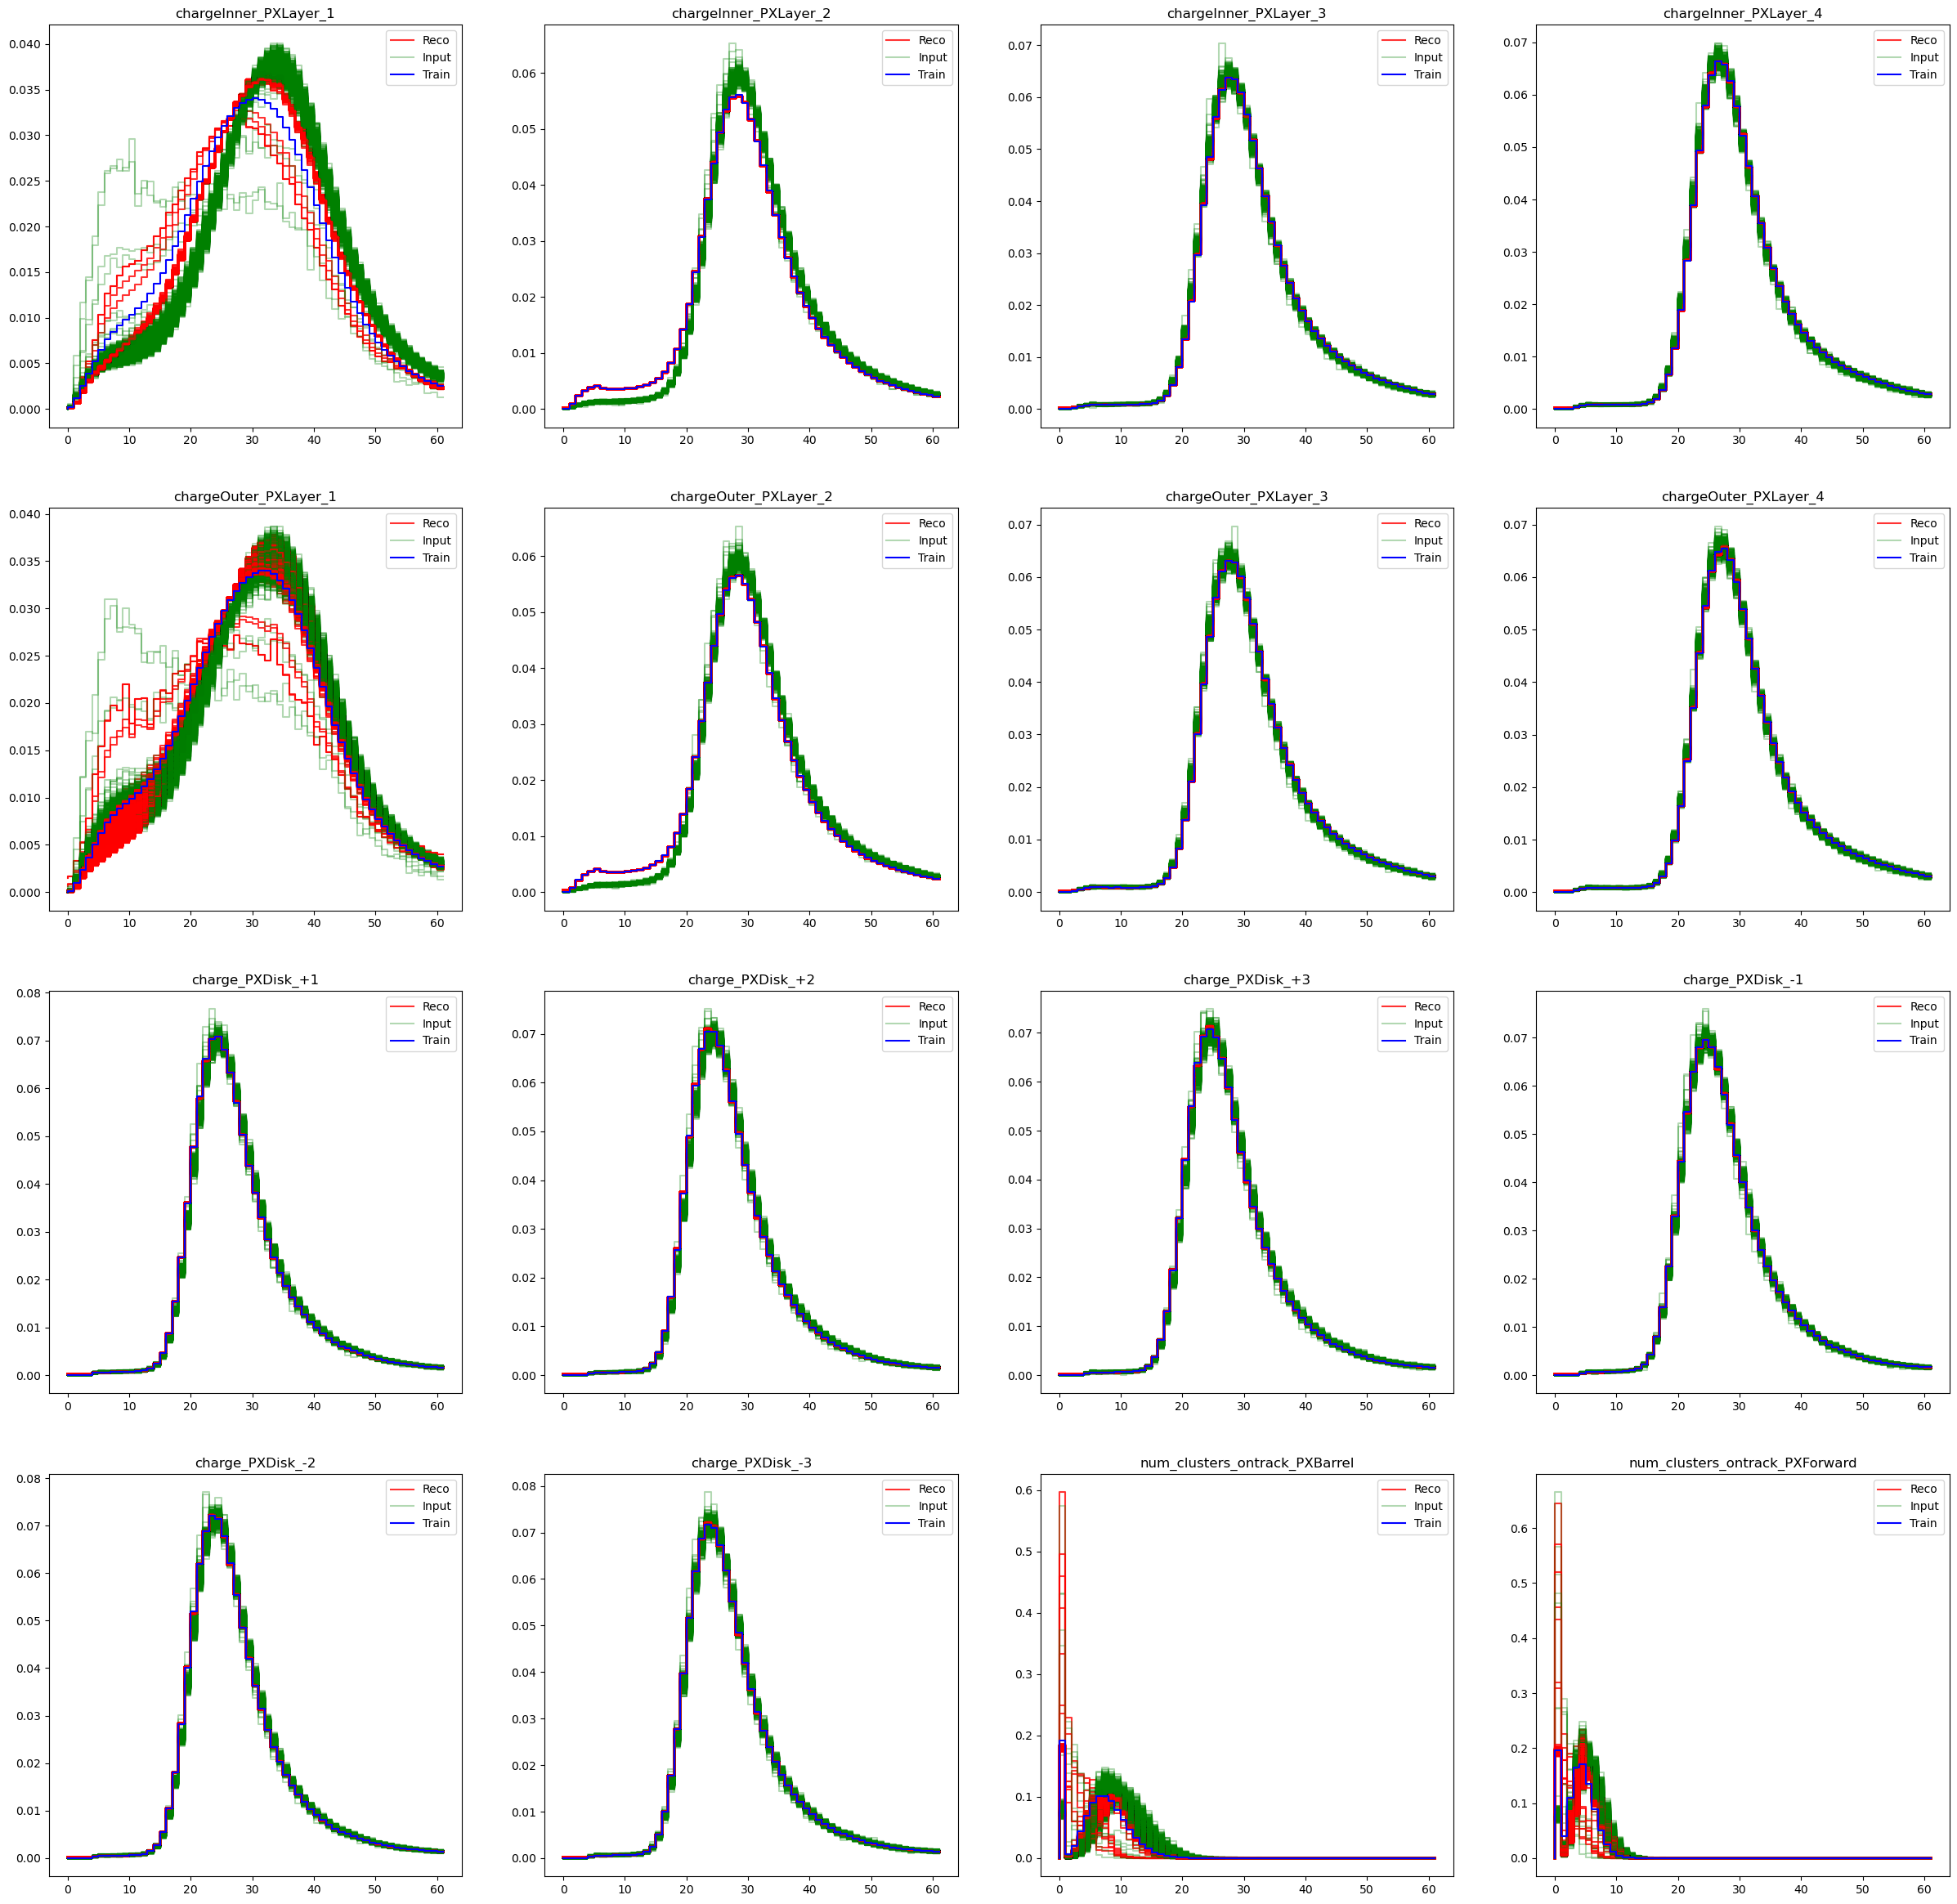

In [120]:
pltu.plotallMEs(eval_recos, evalruns_norm, Xs_train_norm, monitoring_elems, k=0, dpi=100)

Note that for this run, there are clearly lumisections for which there are histograms that show some clearly anomalous behavior. Whether or not this would make the whole lumisection "bad" would be something that would need to be consuled with an expert.

To get a better idea of the quality of the certifications, we subdivide the runs which are closests to the reference run into three different sets.

In [123]:
# Getting runs which are close to the reference run
accSimConds_df = acc_df.loc[:297620]

# Getting runs with a low minimum in the monitoring element accuracies
accSimCondslowmin_df = accSimConds_df[accSimConds_df.loc[:, 'chargeInner_PXLayer_1':].T.describe().loc['min'] < 0.90].reset_index()

# Getting runs with low goodness
accSimCondslowgoodness_df = accSimConds_df[accSimConds_df['meanacc'] < 0.90]

In [133]:
accSimCondslowmin_df

fromrun  fracabove90  above90   meanacc  chargeInner_PXLayer_1  \
0   297099       0.8750       14  0.875000                 1.0000   
1   297101       0.9375       15  0.943344                 0.9967   
2   297215       0.8750       14  0.875000                 1.0000   
3   297218       0.8750       14  0.933333                 1.0000   
4   297604       0.7500       12  0.862307                 1.0000   

   chargeInner_PXLayer_2  chargeInner_PXLayer_3  chargeInner_PXLayer_4  \
0                    1.0                    1.0               1.000000   
1                    1.0                    1.0               1.000000   
2                    1.0                    1.0               1.000000   
3                    1.0                    1.0               1.000000   
4                    1.0                    1.0               0.997429   

   chargeOuter_PXLayer_1  chargeOuter_PXLayer_2  chargeOuter_PXLayer_3  \
0                 1.0000                    1.0                    1.0   
1                 0.9978                    1.0                    1.0   
2                 1.0000                    1.0                    1.0   
3                 1.0000                    1.0                    1.0   
4                 1.0000                    1.0                    1.0   

   chargeOuter_PXLayer_4  charge_PXDisk_+1  charge_PXDisk_+2  \
0                    1.0          1.000000          1.000000   
1                    1.0          1.000000          1.000000   
2                    1.0          1.000000          1.000000   
3                    1.0          1.000000          1.000000   
4                    1.0          0.298201          0.874036   

   charge_PXDisk_+3  charge_PXDisk_-1  charge_PXDisk_-2  charge_PXDisk_-3  \
0          1.000000           1.00000          1.000000          1.000000   
1          1.000000           1.00000          1.000000          1.000000   
2          1.000000           1.00000          1.000000          1.000000   
3          1.000000           1.00000          1.000000          1.000000   
4          0.997429           0.07455          0.586118          0.969152   

   num_clusters_ontrack_PXBarrel  num_clusters_ontrack_PXForward  
0                       0.000000                        0.000000  
1                       0.910891                        0.188119  
2                       0.000000                        0.000000  
3                       0.466667                        0.466667  
4                       1.000000                        1.000000

In [132]:
accSimCondslowgoodness_df.reset_index()

fromrun  fracabove90  above90   meanacc  chargeInner_PXLayer_1  \
0   297099        0.875       14  0.875000                    1.0   
1   297215        0.875       14  0.875000                    1.0   
2   297604        0.750       12  0.862307                    1.0   

   chargeInner_PXLayer_2  chargeInner_PXLayer_3  chargeInner_PXLayer_4  \
0                    1.0                    1.0               1.000000   
1                    1.0                    1.0               1.000000   
2                    1.0                    1.0               0.997429   

   chargeOuter_PXLayer_1  chargeOuter_PXLayer_2  chargeOuter_PXLayer_3  \
0                    1.0                    1.0                    1.0   
1                    1.0                    1.0                    1.0   
2                    1.0                    1.0                    1.0   

   chargeOuter_PXLayer_4  charge_PXDisk_+1  charge_PXDisk_+2  \
0                    1.0          1.000000          1.000000   
1                    1.0          1.000000          1.000000   
2                    1.0          0.298201          0.874036   

   charge_PXDisk_+3  charge_PXDisk_-1  charge_PXDisk_-2  charge_PXDisk_-3  \
0          1.000000           1.00000          1.000000          1.000000   
1          1.000000           1.00000          1.000000          1.000000   
2          0.997429           0.07455          0.586118          0.969152   

   num_clusters_ontrack_PXBarrel  num_clusters_ontrack_PXForward  
0                            0.0                             0.0  
1                            0.0                             0.0  
2                            1.0                             1.0

Lets say that the runs which are both in the low minimum accuracy and the low goodness score dataframes will be considered "bad".

In [161]:
accSimCondslowmin = accSimCondslowmin_df.reset_index()['fromrun'].to_list()
accSimCondslowgoodness = accSimCondslowgoodness_df.reset_index()['fromrun'].to_list()
accSimCondsbad = list(set(accSimCondslowmin) & set(accSimCondslowgoodness))

# accSimCondsAnomalous = accSimCondsAnomalous_df['fromrun'].to_list()
print('Runs with low minimum accuracy: ', accSimCondslowmin)
print('Runs with low goodness score: ', accSimCondslowgoodness)
print('Runs which fall into both categories: ', accSimCondsbad)

Runs with low minimum accuracy:  [297099, 297101, 297215, 297218, 297604]
Runs with low goodness score:  [297099, 297215, 297604]
Runs which fall into both categories:  [297099, 297604, 297215]


In [168]:
# Plotting all potentially anomalous runs
i_bad = []
for run in accSimCondsbad:
    print(run)
    i_bad.append(acc_df.reset_index()[acc_df.reset_index()['fromrun']==run].index.values.astype(int)[0])
i_bad

297099
297604
297215


[2, 21, 8]

Now plotting run 297099


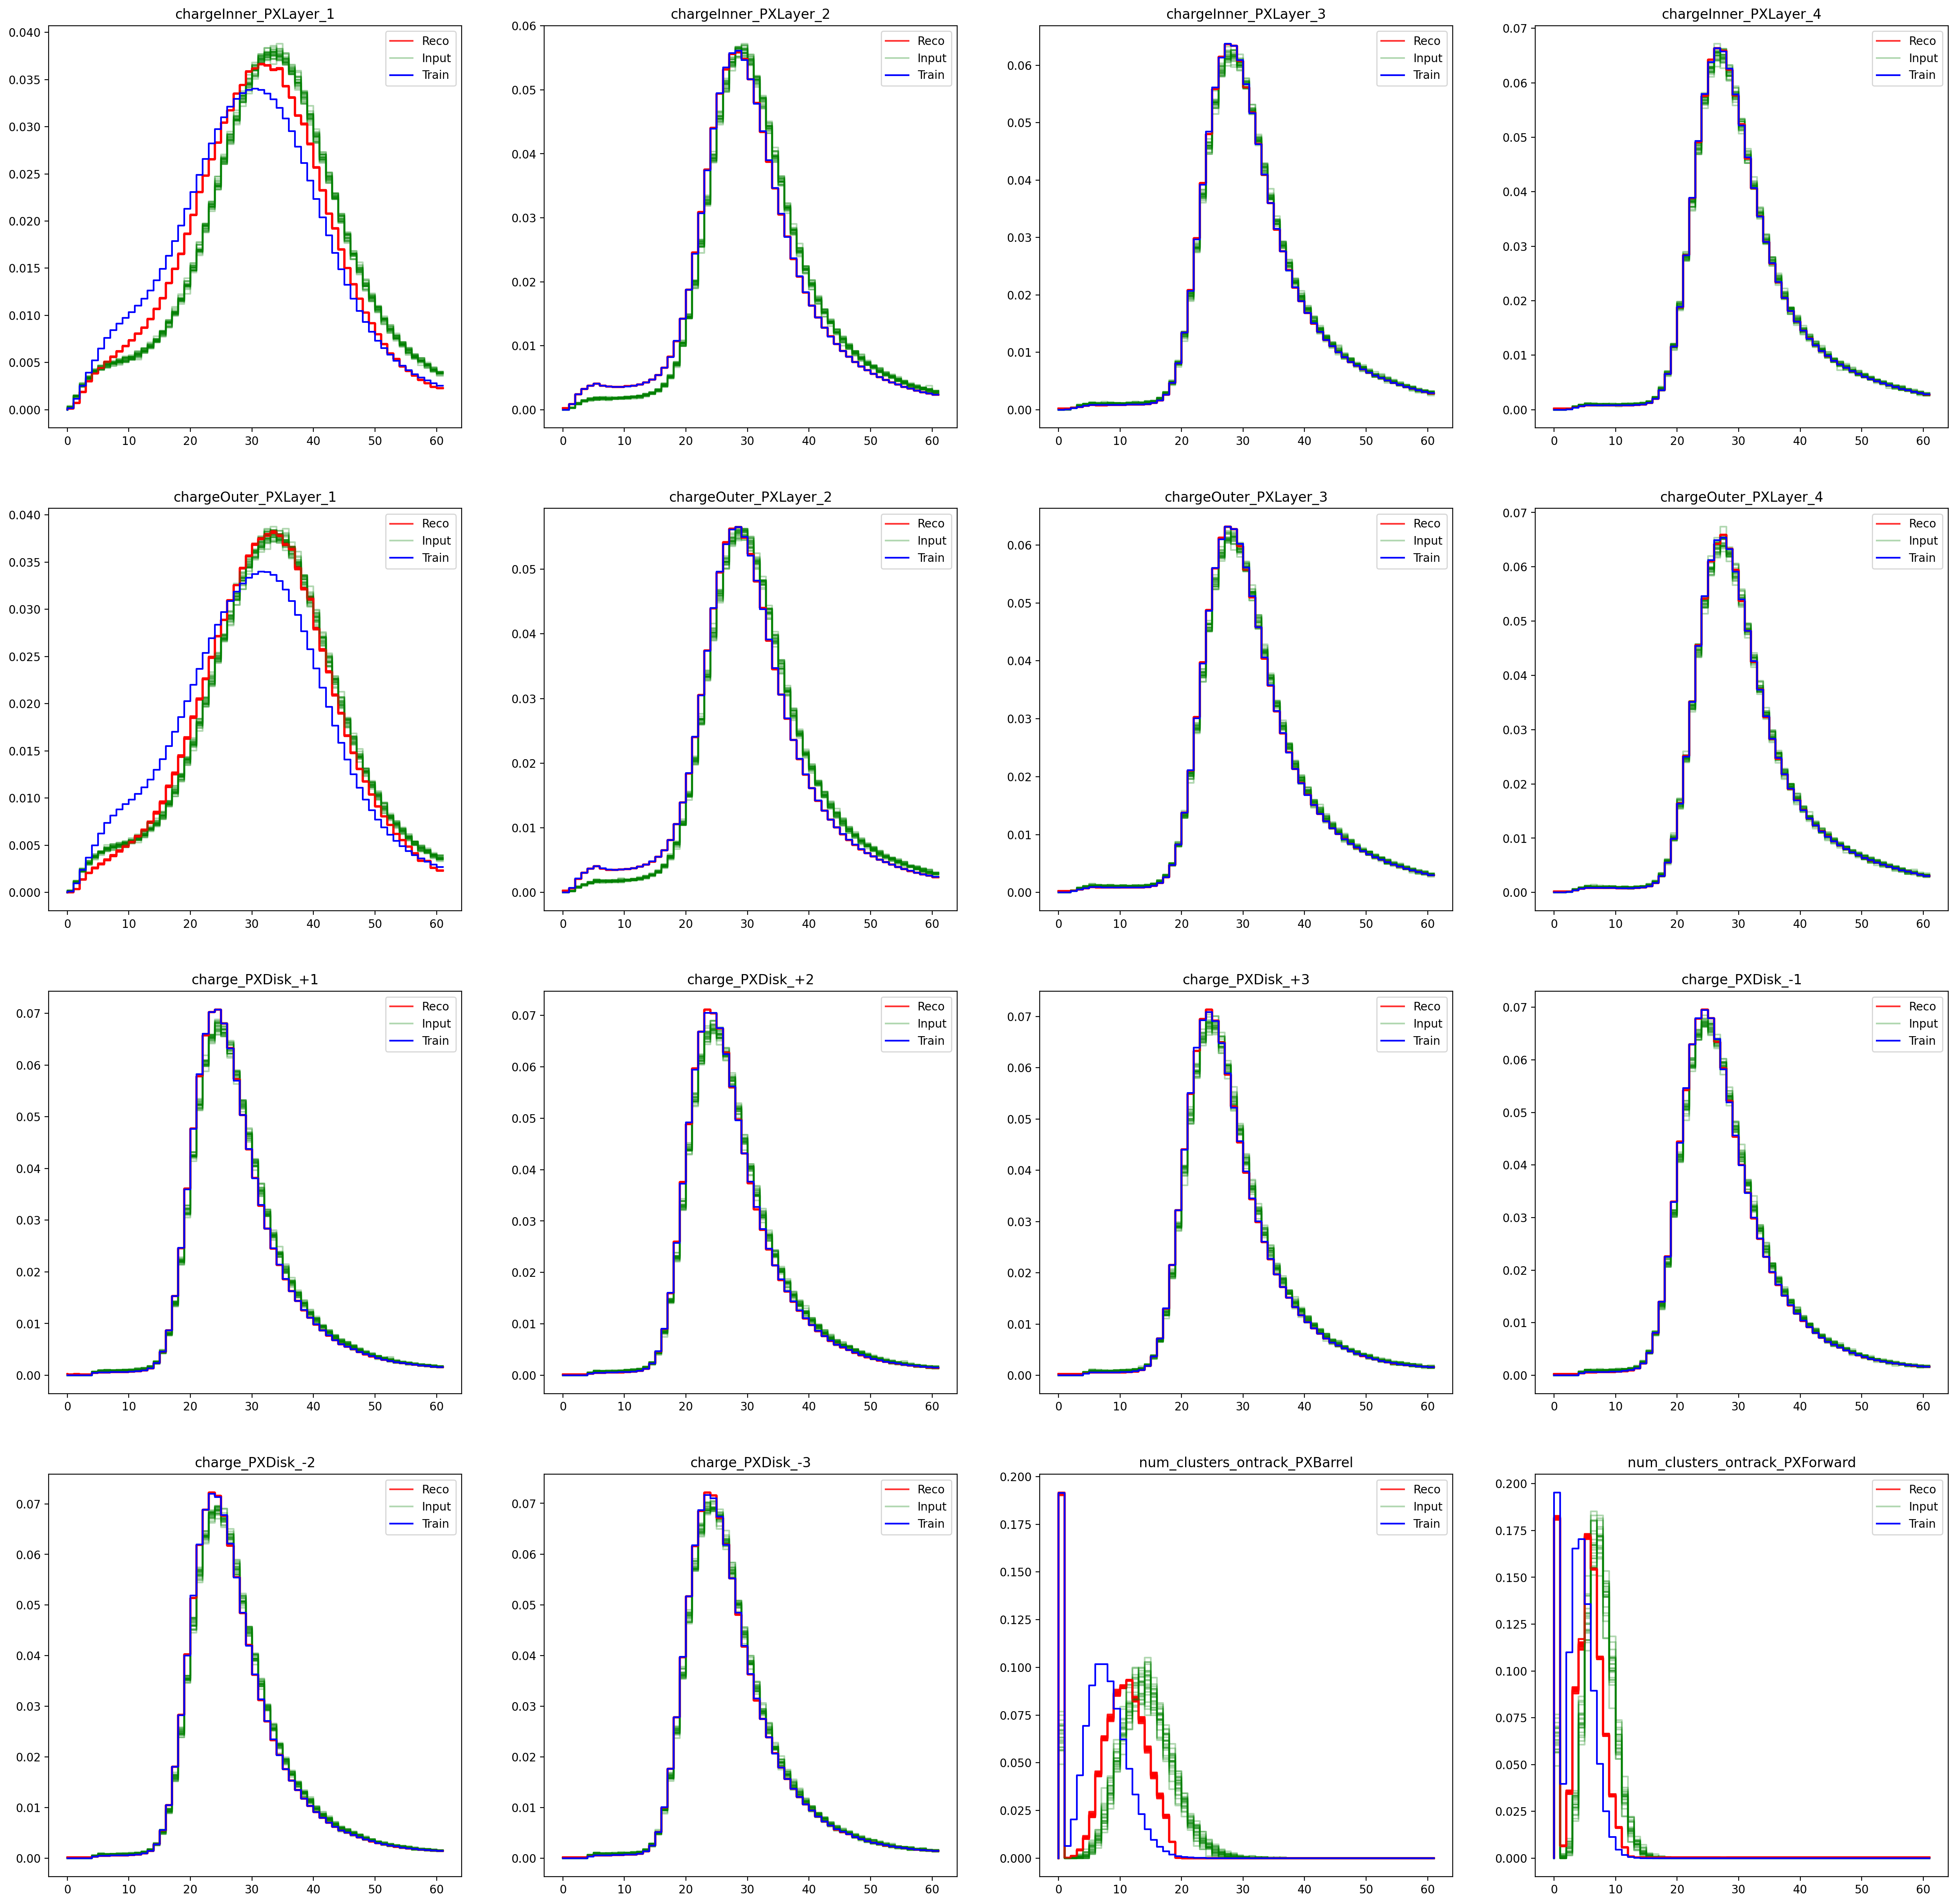

Now plotting run 297604


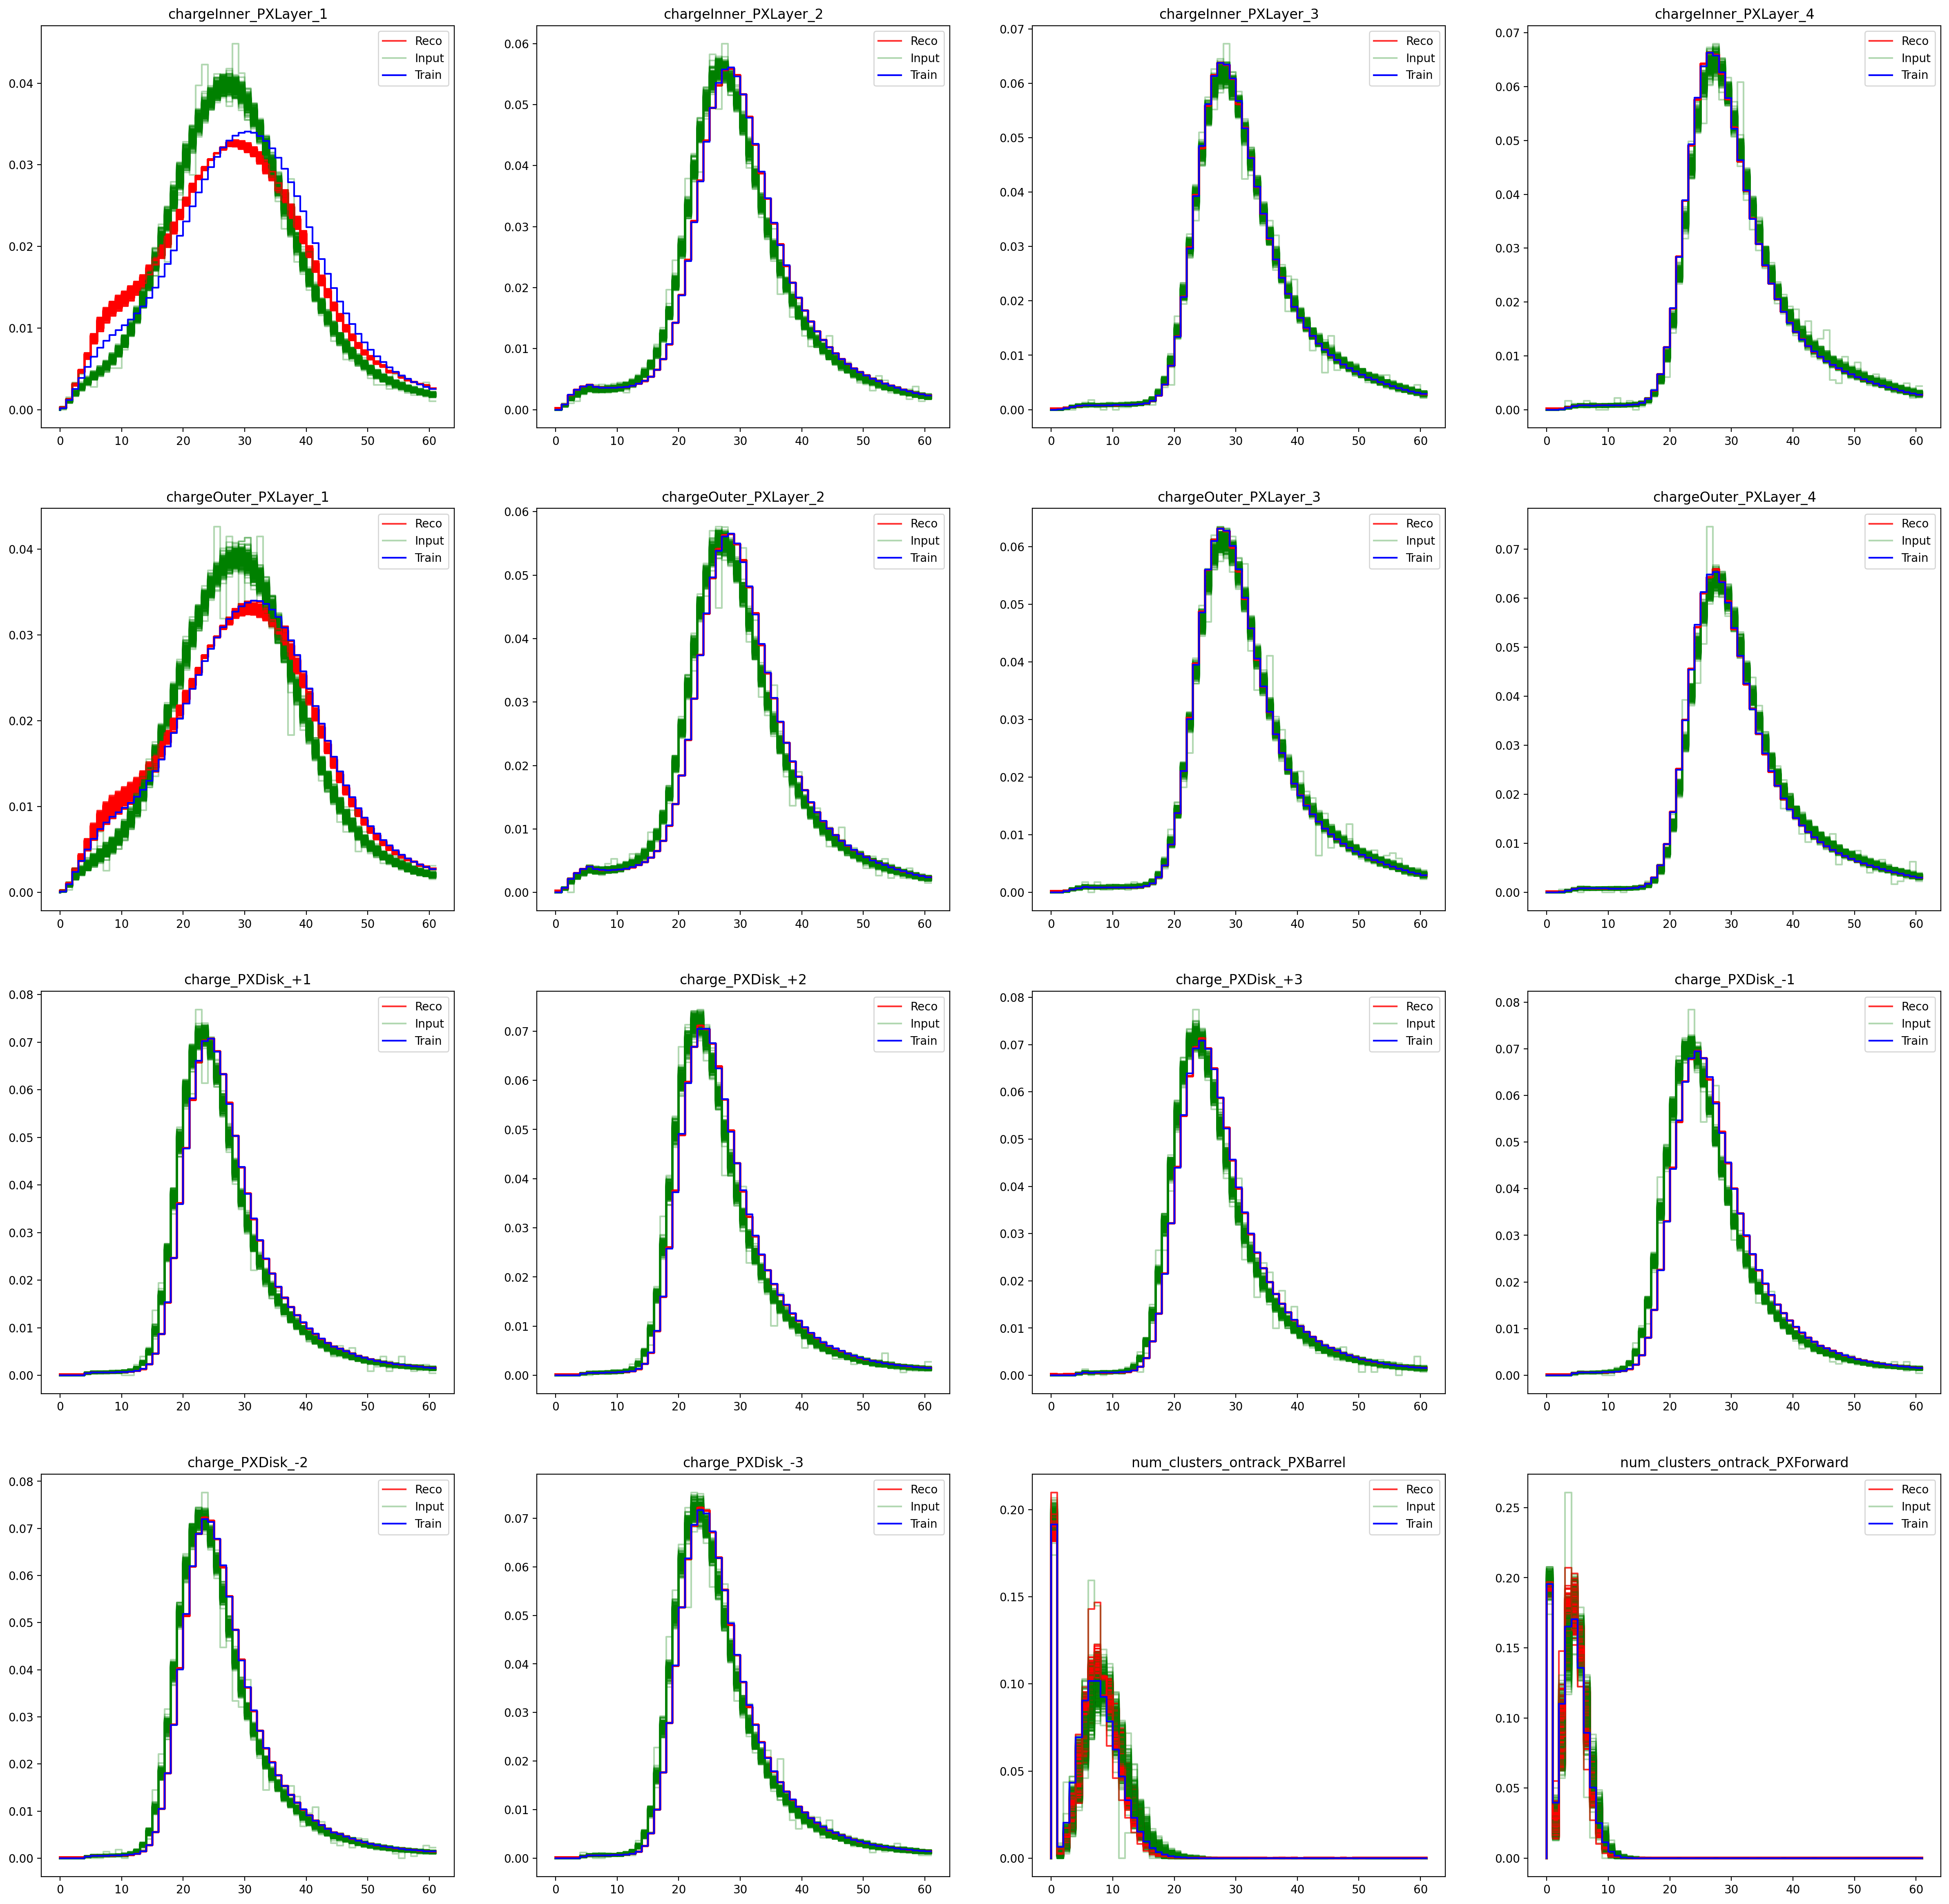

Now plotting run 297215


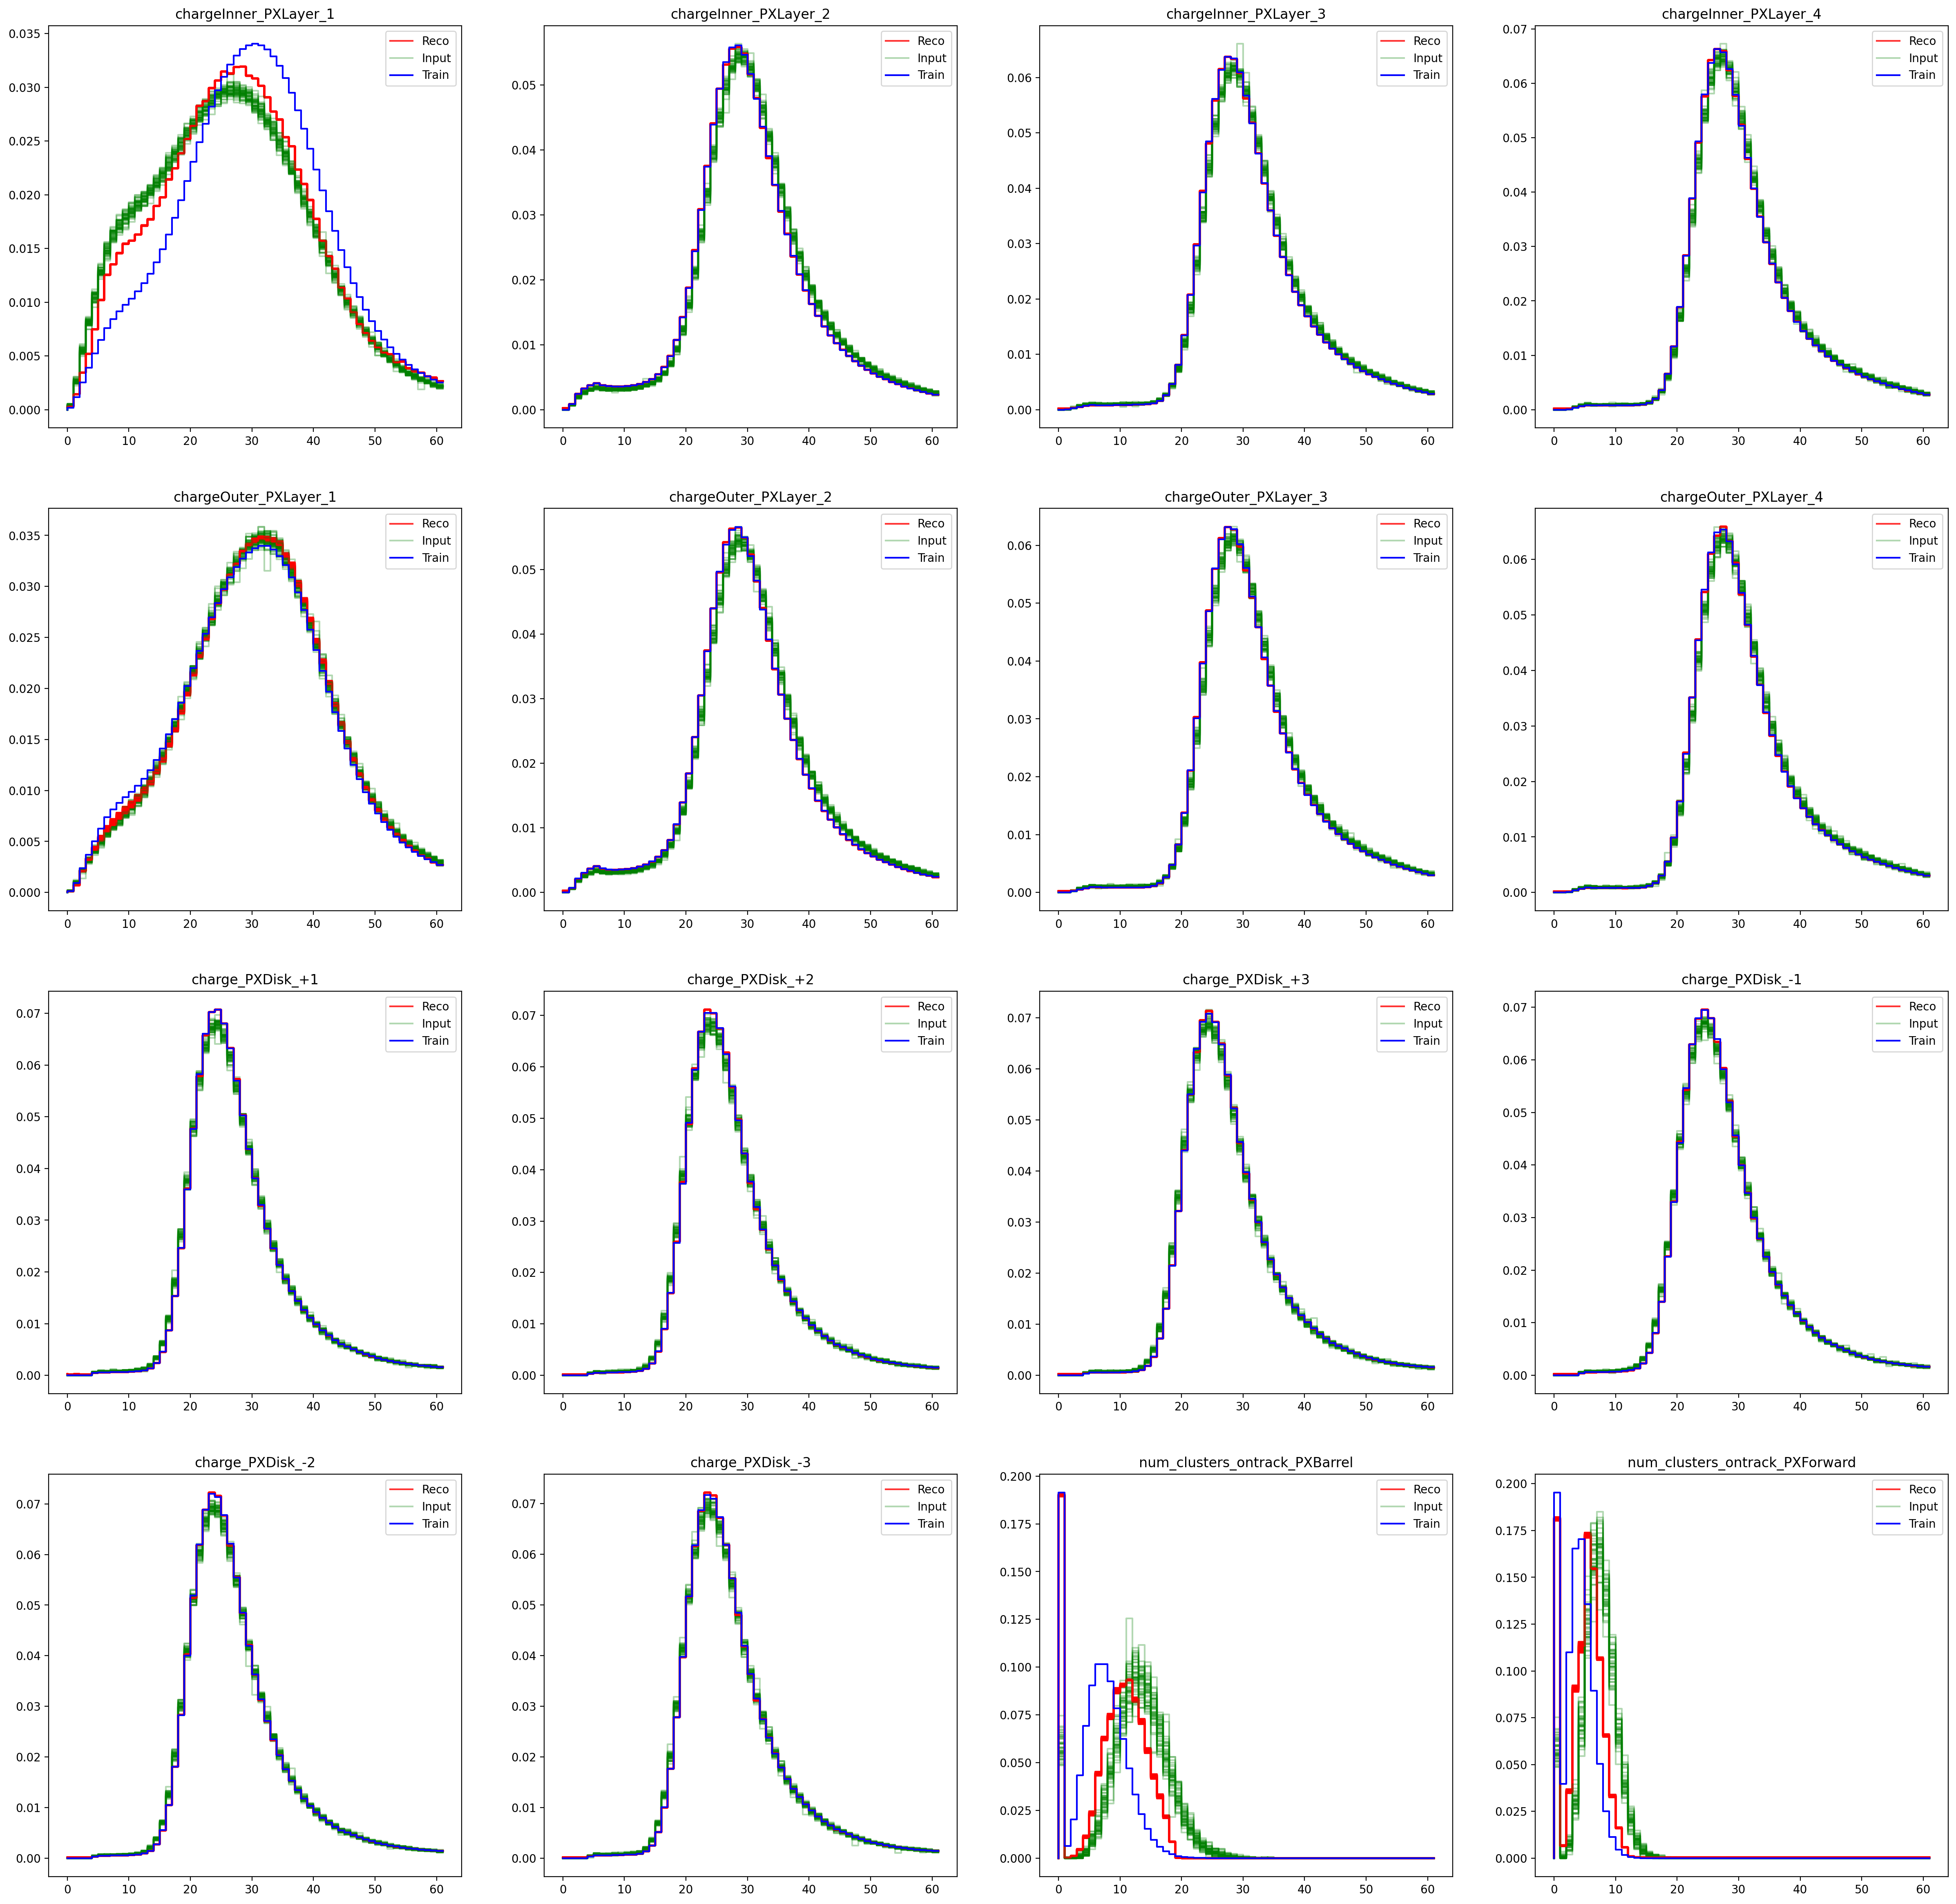

In [169]:
for index in i_bad:
    print('Now plotting run', acc_df.index[index])
    pltu.plotallMEs(eval_recos, evalruns_norm, Xs_train_norm, monitoring_elems, k=index)

We can see that these runs, despite having both the lowest minimum accuracy and the lowest goodness score, actually seem okay.

In [170]:
# Total num of LSs
totalLSs = 0
for reco in eval_recos:
    totalLSs += reco.shape[1]
totalLSs *= 16
print('Total number of LSs:', totalLSs)

Total number of LSs: 172912


<h1><font color='blue'>Conclusions</font></h1>

- While some potential anomalous lumisections slip through data certification (as seen with run 297050, whether or not these observed anomalous behaviors warrant a "bad" certification for those lumisections remains be seen, as the input of an expert would be neccessary.
- The limited applicability of the model and of the reference run used to train it are evident in the downward trend of the goodness score. We can hypothesize that this is caused by changing data-taking conditions and not by there being anything wrong with those runs.